In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split,RandomizedSearchCV,cross_val_score,GridSearchCV,cross_validate
import sklearn.metrics as metrics 
import matplotlib.cm as cm

# algorithms
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# data preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

# metrics
from sklearn.metrics import mean_squared_error, r2_score ,explained_variance_score


In [2]:
df_ = pd.read_excel("/Users/zaferavci/Documents/GitHub/Miuul-CaseStudy-1/Miuul-Case-Study/oppurtunity.xlsx", header=0) 

In [3]:
df = df_

In [4]:
df.columns = [col.lower() for col in df.columns]

In [5]:
df.head()

opp. id           contactid          recordtype.name  \
0  0065G00000WOEXGQA5                 NaN         Expansion Income   
1  0065G00000WOEdEQAX  003f400000GtceBAAR  Silent Auction Purchase   
2  0065G00000WOEf0QAH  003f400001IklhmAAB                 Donation   
3  0065G00000WOEf1QAH  0035G00001aanl2QAA                 Donation   
4  0065G00000WOEf2QAH  0035G00001aanl3QAA                 Donation   

  account.name  amount platform__c  closedate donation_date__c   stagename  \
0        `3613   200.0         NaN 2020-10-22              NaT     Awarded   
1        `5059  2550.0         NaN 2020-06-30              NaT  Closed Won   
2        `0211    50.0    Facebook 2020-10-12              NaT  Closed Won   
3        `0219    80.0    Facebook 2020-10-16              NaT  Closed Won   
4        `0277    10.0    Facebook 2020-10-15              NaT  Closed Won   

  campaign.name  
0           NaN  
1      2020 EWC  
2           NaN  
3           NaN  
4           NaN

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   opp. id           16000 non-null  object        
 1   contactid         15069 non-null  object        
 2   recordtype.name   16000 non-null  object        
 3   account.name      15996 non-null  object        
 4   amount            15618 non-null  float64       
 5   platform__c       13849 non-null  object        
 6   closedate         16000 non-null  datetime64[ns]
 7   donation_date__c  7557 non-null   datetime64[ns]
 8   stagename         16000 non-null  object        
 9   campaign.name     12503 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(7)
memory usage: 1.2+ MB


In [7]:
df.describe([0.05,0.1,0.5,0.75,0.90,0.95,0.99]).T

count                           mean                  min  \
amount            15618.0                     599.650734                  0.0   
closedate           16000  2022-10-06 08:17:09.599999744  2017-01-23 00:00:00   
donation_date__c     7557  2024-01-19 05:37:28.034934528  2021-04-19 00:00:00   

                                   5%                            10%  \
amount                           10.0                           20.0   
closedate         2018-04-26 00:00:00  2020-05-28 09:36:00.000001280   
donation_date__c  2023-03-03 00:00:00            2023-04-13 00:00:00   

                                  50%                  75%  \
amount                           50.0                105.0   
closedate         2023-03-08 00:00:00  2024-01-17 06:00:00   
donation_date__c  2023-12-18 00:00:00  2024-08-14 00:00:00   

                                  90%                  95%  \
amount                          750.0               1500.0   
closedate         2024-09-23 00:00:00  2024-12-17 00:00:00   
donation_date__c  2024-11-14 00:00:00  2024-12-18 00:00:00   

                                  99%                  max          std  
amount                     10266.7371             550000.0  5621.051114  
closedate         2025-07-01 00:00:00  2026-03-20 00:00:00          NaN  
donation_date__c  2025-03-04 00:00:00  2025-03-13 00:00:00          NaN

In [8]:
df.describe(include='O').T   #df.describe(include='all').T  tüm verileri ayni tabloda incelemek icin..

count unique                 top   freq
opp. id          16000  16000  0065G00000WOEXGQA5      1
contactid        15069   8200  003f400000FhJtbAAF    100
recordtype.name  16000      7            Donation  15296
account.name     15996   5514               `4244    100
platform__c      13849     26                Qgiv   3914
stagename        16000     14          Closed Won  14756
campaign.name    12503    166            2023 EKC    749

In [9]:
df.isnull().sum()

opp. id                0
contactid            931
recordtype.name        0
account.name           4
amount               382
platform__c         2151
closedate              0
donation_date__c    8443
stagename              0
campaign.name       3497
dtype: int64

In [10]:
# Eksik değerlerin sayısı ve yüzdesi
missing_df = df.isnull().sum().to_frame(name='Missing Count')
missing_df['Missing Ratio (%)'] = 100 * missing_df['Missing Count'] / len(df)
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)


In [11]:
missing_df

Missing Count  Missing Ratio (%)
donation_date__c           8443           52.76875
campaign.name              3497           21.85625
platform__c                2151           13.44375
contactid                   931            5.81875
amount                      382            2.38750
account.name                  4            0.02500

Missing Valueların Doldurulması

In [12]:
# 1. 'donation_date__c' kolonunu tamamen sil
df.drop(columns=['donation_date__c'], inplace=True)

In [13]:
# 2. 'campaign.name' eksiklerini 'No campaign' ile doldur
df['campaign.name'] = df['campaign.name'].fillna('No campaign')

In [14]:
df['amount'].sum()

np.float64(9365345.17)

In [15]:
# 3. 'contactid' ve 'account.name' boş olan satırları sil
df.dropna(subset=['contactid', 'account.name'], inplace=True)

In [16]:
df['amount'].sum()

np.float64(4216587.09)

In [17]:
# 4. 'amount' eksiklerini medyan ile doldur
df['amount'] = df['amount'].fillna(df['amount'].median())

In [18]:
df['amount'].sum()

np.float64(4233937.09)

Platform_c nin Campaign name ilişkisine göre koşullu mod ile doldurulması

In [19]:
# Adım 1: Kırılma noktasını düzeltiyoruz – to_frame'e özel isim veriyoruz
campaign_platform_ratio = (
    df[df['platform__c'].notnull()]
    .groupby(['campaign.name', 'platform__c'])
    .size()
    .reset_index(name='count')  # Bu artık tekrar etmeyen isim olacak
)

# Adım 2: Toplam kampanya sayısına göre oranları hesapla
total_counts = campaign_platform_ratio.groupby('campaign.name')['count'].transform('sum')
campaign_platform_ratio['ratio'] = campaign_platform_ratio['count'] / total_counts

In [20]:
campaign_platform_ratio

campaign.name  platform__c  count     ratio
0                 10 for 10     Facebook     64  1.000000
1                  2019 EWC  CTK Website      2  0.666667
2                  2019 EWC        Check      1  0.333333
3         2019 Summer Event        Check      1  1.000000
4                  2020 EWC  Give Lively      4  0.800000
..                      ...          ...    ...       ...
402              United Way        Check      5  0.065789
403              United Way       Truist     63  0.828947
404              United Way   United Way      8  0.105263
405  Welliver Memorial 2020  CTK Website      4  0.190476
406  Welliver Memorial 2020  Give Lively     17  0.809524

[407 rows x 4 columns]

In [21]:
# %90 üzeri eşleşmeleri al  
strong_matches = campaign_platform_ratio[campaign_platform_ratio['ratio'] >= 0.9]

# Sözlük oluştur: {'Campaign.Name': 'Platform__c'}
campaign_to_platform = dict(zip(strong_matches['campaign.name'], strong_matches['platform__c']))

In [22]:
campaign_to_platform

{'10 for 10': 'Facebook',
 '2019 Summer Event': 'Check',
 '2020 Thank You': 'CTK Website',
 '2021 EWC Peer-to-Peer': 'Qgiv',
 '2021 EWC Reminder Postcard 4.26.21': 'Qgiv',
 '2021 EWC Table Captains': 'Qgiv',
 '2021 EWC Text to Give': 'Give Lively',
 '2022 EWC Board Pledges': 'Check',
 '2022 Giving Tuesday | Together We Count': 'Facebook',
 '2022 HBD Birthday Campaign': 'Give Lively',
 '2022 HBD Birthday Campgian': 'Give Lively',
 '2022 Honoring CJ': 'Give Lively',
 '2022 Kendra Scott Giveback Event': 'Check',
 '2023 CM In Person Ticket': 'FundEasy',
 '2023 CM Silent Auction': 'Square',
 '2023 EKC': 'PledgeIt',
 '2023 EKC Golf Tournament Foursome': 'FundEasy',
 '2023 EKC Golf Tournament In-Kind Donors': 'Check',
 '2023 EKC Golf Tournament Silent Auction': 'HBD Website',
 '2023 Gamechangers': 'PledgeIt',
 "2023 Lydie's Loop Donations": 'Qgiv',
 "2023 Lydie's Loop Registration": 'Qgiv',
 '2023 MCH Symposium Exhibitor': 'CTK Website',
 '2023 Walk of Remembrance': 'Qgiv',
 '2023 Walk of Rem

In [23]:
from tqdm import tqdm

for i in tqdm(df[df['platform__c'].isnull()].index):

    campaign = df.loc[i, 'campaign.name']
    recordtype = df.loc[i, 'recordtype.name']

    # 1. Kampanyaya göre doldur
    if campaign in campaign_to_platform:
        df.at[i, 'platform__c'] = campaign_to_platform[campaign]

    # 2. Kampanya eşleşmedi, record type'a göre mod
    elif pd.notnull(recordtype):
        platform_mode = df[df['recordtype.name'] == recordtype]['platform__c'].mode()
        if not platform_mode.empty:
            df.at[i, 'platform__c'] = platform_mode[0]

    # 3. Hiçbir şey yoksa genel mod
    else:
        overall_mode = df['platform__c'].mode()
        if not overall_mode.empty:
            df.at[i, 'platform__c'] = overall_mode[0]

100%|██████████████████████████████████████| 1853/1853 [00:02<00:00, 869.46it/s]


In [24]:
df.isnull().sum()

opp. id            0
contactid          0
recordtype.name    0
account.name       0
amount             0
platform__c        0
closedate          0
stagename          0
campaign.name      0
dtype: int64

In [25]:
# İlk olarak tüm object ve category kolonlarını al
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# ID gibi analizde kullanmak istemediğimiz kolonları çıkar
id_cols = ['opp. id', 'contactid', 'account.name']
cat_cols = [col for col in cat_cols if col not in id_cols]

# Sayısal kolonlar
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Tarih kolonları
date_cols = df.select_dtypes(include=['datetime']).columns.tolist()

# Sonuçları görelim
print("Kategorik Değişkenler:", cat_cols)
print("Sayısal Değişkenler:", num_cols)
print("Tarih Değişkenleri:", date_cols)

Kategorik Değişkenler: ['recordtype.name', 'platform__c', 'stagename', 'campaign.name']
Sayısal Değişkenler: ['amount']
Tarih Değişkenleri: ['closedate']


Kategorik Değişkenler

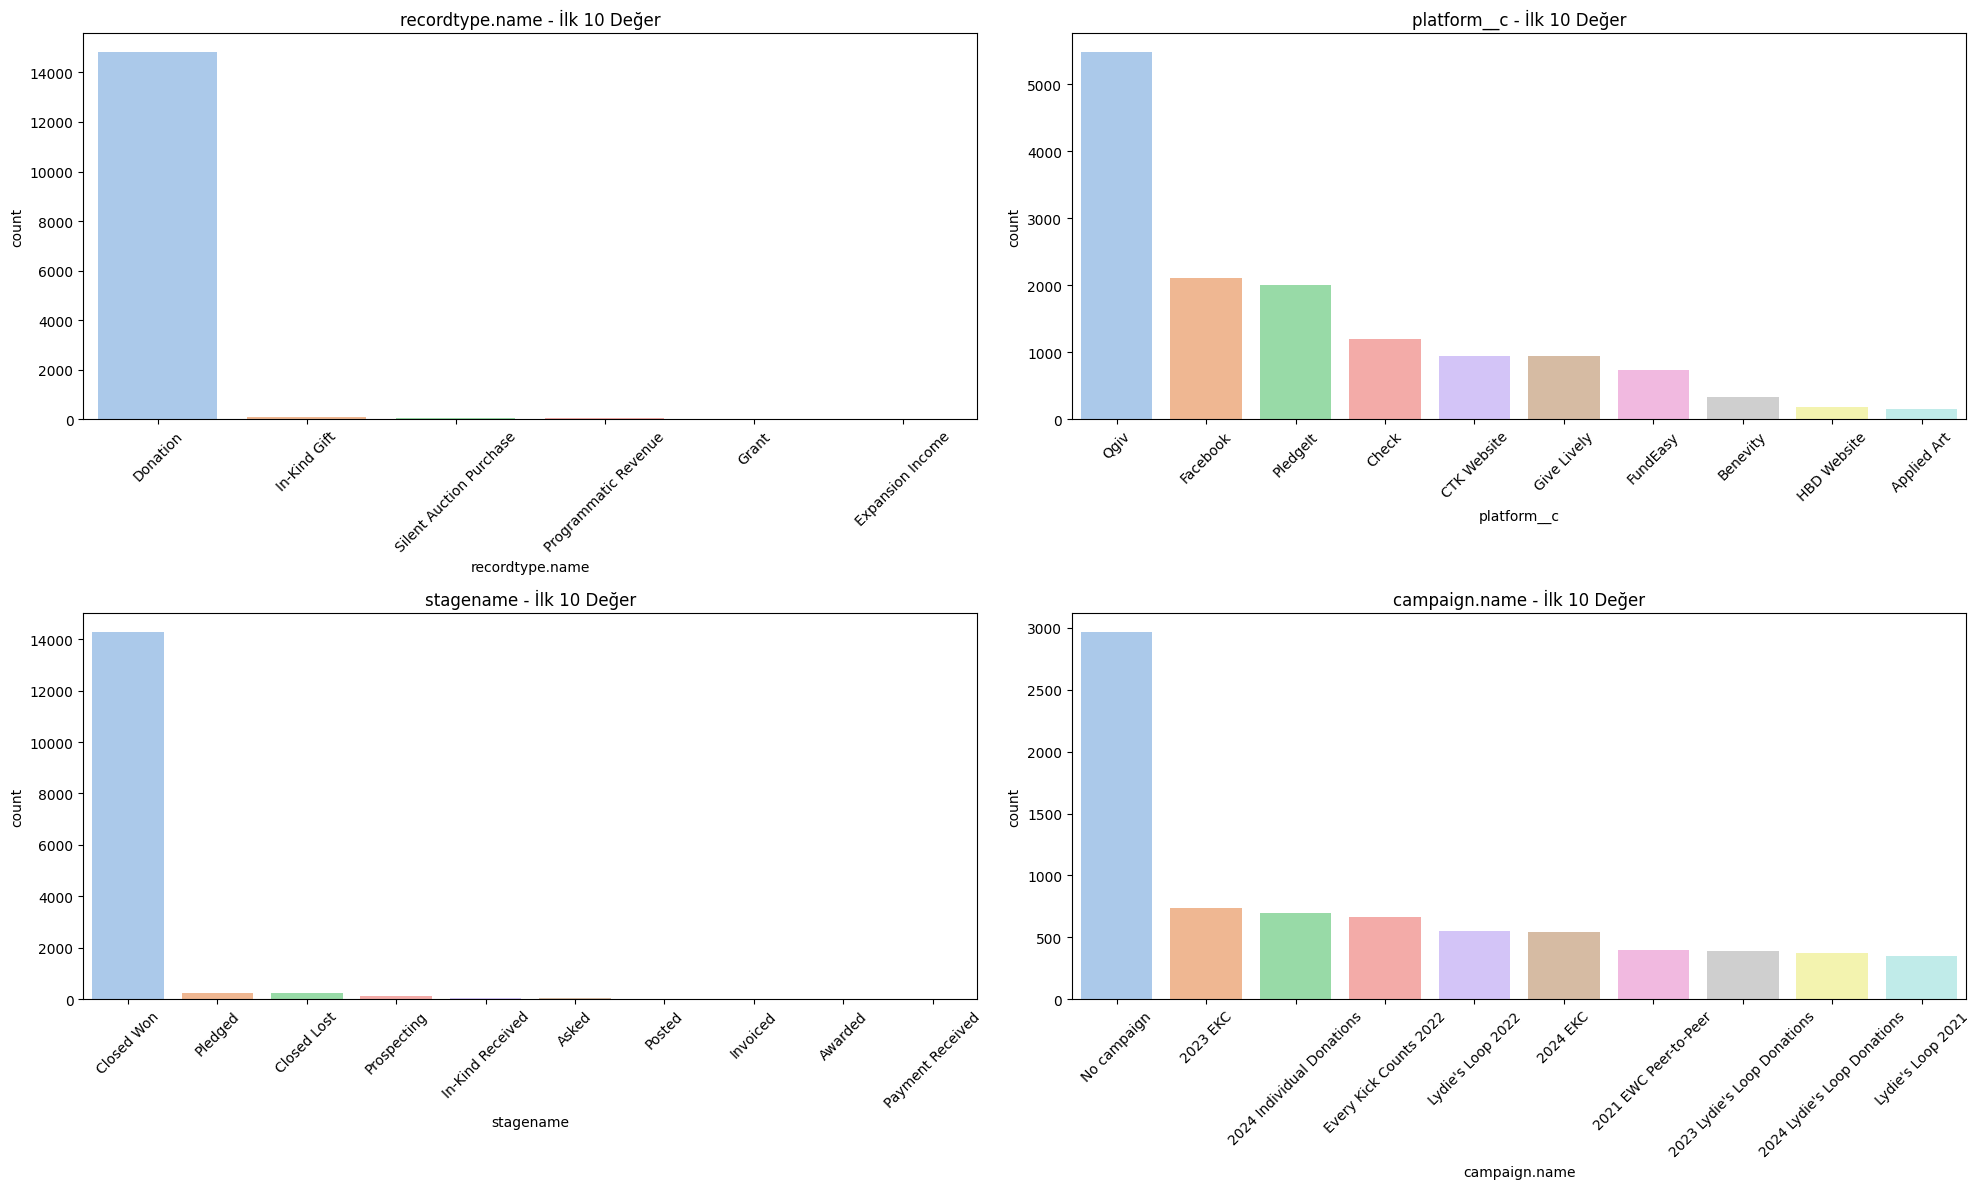

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

cat_cols = ['recordtype.name', 'platform__c', 'stagename', 'campaign.name']

plt.figure(figsize=(20, 12))
for i, col in enumerate(cat_cols):
    plt.subplot(2, 2, i + 1)
    order = df[col].value_counts().head(10).index  # En çok görülen 10 kategori
    sns.countplot(data=df, x=col, order=order, palette='pastel')  # pastel renk paleti
    plt.title(f"{col} - İlk 10 Değer")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Sayısal Değişken

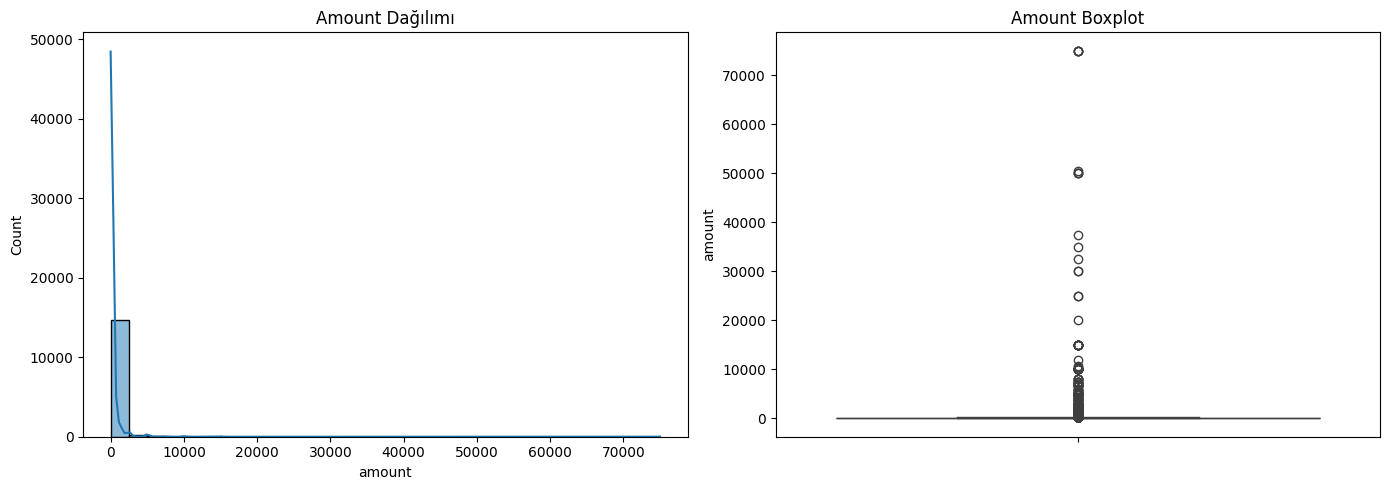

In [27]:
plt.figure(figsize=(14, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df['amount'], kde=True, bins=30)
plt.title("Amount Dağılımı")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data=df, y='amount')
plt.title("Amount Boxplot")

plt.tight_layout()
plt.show()


In [28]:
def calculate_LB_UB (df,var):
    '''calculating upper bound and lower bound values to identify outliers'''
    Q3=np.percentile(df[var],75)
    Q1=np.percentile(df[var],25)
    IQR=1.5*(Q3-Q1)
    
    UB=Q3+IQR
    LB=Q1-IQR
    
    print(LB,UB)
    
    return LB,UB

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pastel tema
sns.set_palette("pastel")

# Veri yüklenmiş sayılıyor: df

# Toplam bağış miktarı ve işlem sayısı
total_amount = df["amount"].sum()
total_transactions = df.shape[0]

print(f"Toplam Bağış Miktarı: ${total_amount:,.2f}")
print(f"Toplam Bağış İşlem Sayısı: {total_transactions:,}")


Toplam Bağış Miktarı: $4,233,937.09
Toplam Bağış İşlem Sayısı: 15,065


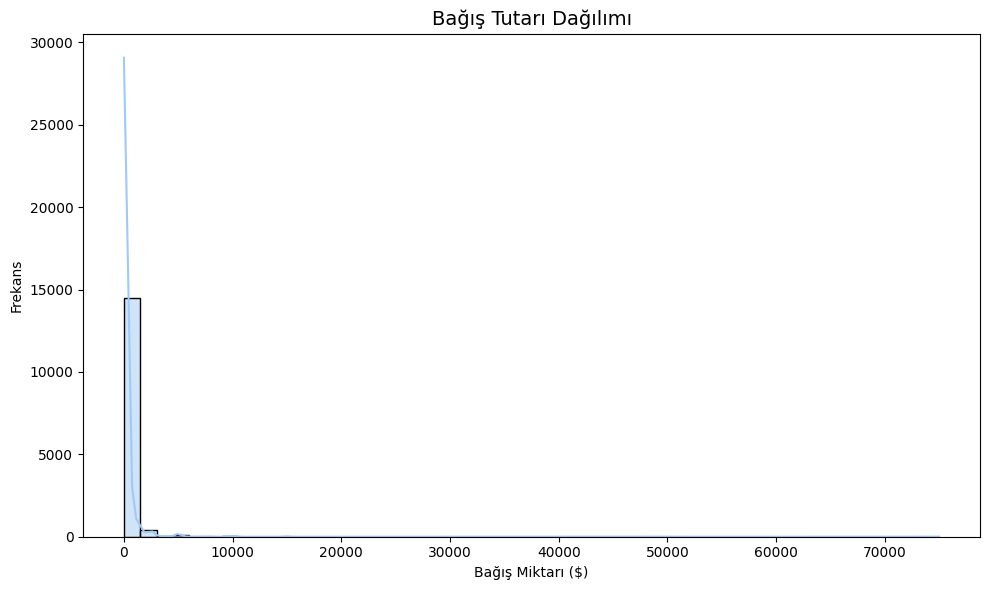

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(df["amount"], bins=50, kde=True)
plt.title("Bağış Tutarı Dağılımı", fontsize=14)
plt.xlabel("Bağış Miktarı ($)")
plt.ylabel("Frekans")
plt.tight_layout()
plt.savefig("amount_dagilim.png", dpi=300)
plt.show()


Toplam Bağış Miktarı: $9,365,345

Toplam İşlem Sayısı: 16,000 bağış kaydı

Histogramdan da görüldüğü gibi:

Çoğu bağış düşük–orta düzeyde, ancak bazı yüksek tutarlı bağışlar (outlier) dağılımı uzatıyor.

Bu, hem geniş katılımlı hem de büyük bağışçıların olduğunu gösteriyor — yatırımcı sunumunda ölçeklenebilirlik açısından değerli bir içgörü.

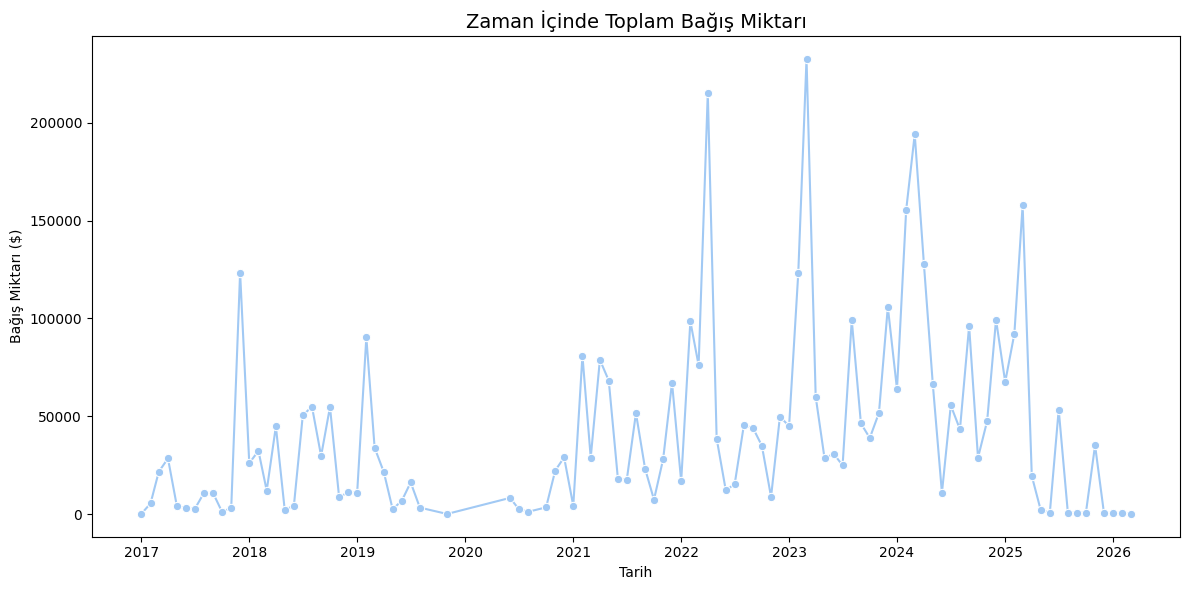

In [31]:
# Tarih sütununu düzenle
df["closedate"] = pd.to_datetime(df["closedate"])

# Aylık bağış trendi
df["year_month"] = df["closedate"].dt.to_period("M")
monthly_trend = df.groupby("year_month")["amount"].sum().reset_index()
monthly_trend["year_month"] = monthly_trend["year_month"].dt.to_timestamp()

# Grafik: Zaman içindeki bağış trendi
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_trend, x="year_month", y="amount", marker="o")
plt.title("Zaman İçinde Toplam Bağış Miktarı", fontsize=14)
plt.xlabel("Tarih")
plt.ylabel("Bağış Miktarı ($)")
plt.tight_layout()
plt.show()


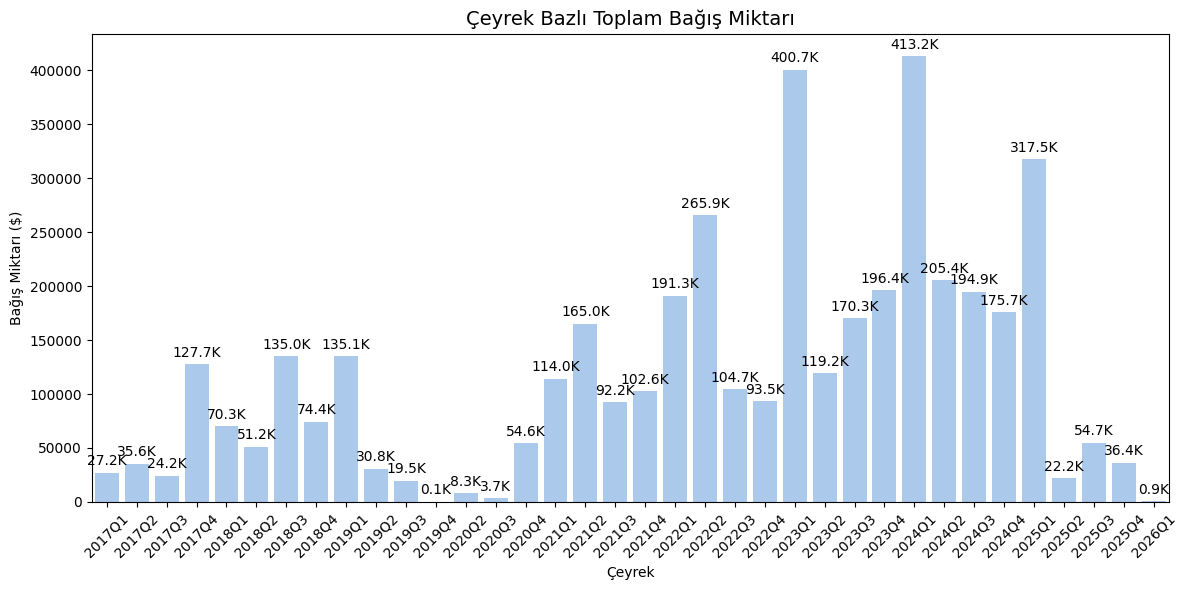

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pastel renk teması
sns.set_palette("pastel")

# Çeyrek bilgisi çıkar
df["quarter"] = df["closedate"].dt.to_period("Q").astype(str)

# Çeyrek bazında toplam bağışlar
quarterly_trend = df.groupby("quarter")["amount"].sum().reset_index()

# Grafik çizimi
plt.figure(figsize=(12, 6))
barplot = sns.barplot(data=quarterly_trend, x="quarter", y="amount")

# Bar'ların üzerine K formatlı etiket ekleyelim
for index, row in quarterly_trend.iterrows():
    value = row["amount"]
    if value > 0:
        label = f"{value/1000:.1f}K"
        barplot.text(index, value + max(quarterly_trend["amount"]) * 0.01, label, ha='center', va='bottom', fontsize=10)

plt.title("Çeyrek Bazlı Toplam Bağış Miktarı", fontsize=14)
plt.xlabel("Çeyrek")
plt.ylabel("Bağış Miktarı ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



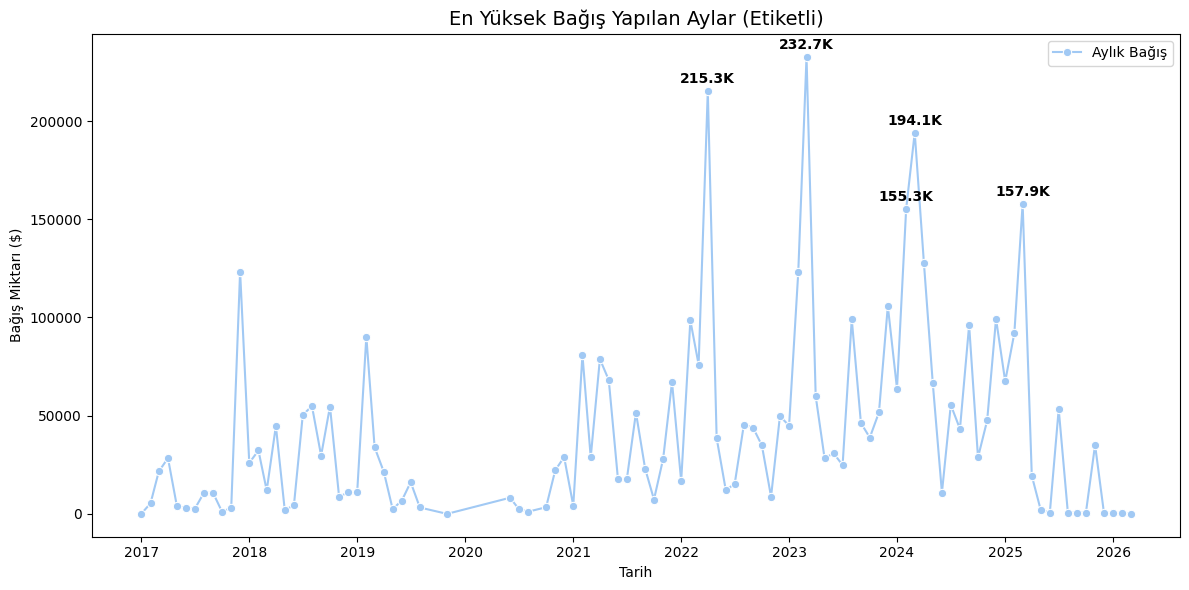

In [33]:
# Ay bilgisi çıkar
df["year_month"] = df["closedate"].dt.to_period("M")
monthly_trend = df.groupby("year_month")["amount"].sum().reset_index()
monthly_trend["year_month"] = monthly_trend["year_month"].dt.to_timestamp()

# En yüksek 5 ay
top_months = monthly_trend.sort_values(by="amount", ascending=False).head(5)

# Grafik çiz
plt.figure(figsize=(12, 6))
sns.set_palette("pastel")
ax = sns.lineplot(data=monthly_trend, x="year_month", y="amount", marker="o", label="Aylık Bağış")

# Etiket ekle sadece en yüksek 5 ay için
for i, row in top_months.iterrows():
    label = f"{row['amount']/1000:.1f}K"
    plt.text(row["year_month"], row["amount"] + max(monthly_trend["amount"])*0.01, label, 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title("En Yüksek Bağış Yapılan Aylar (Etiketli)", fontsize=14)
plt.xlabel("Tarih")
plt.ylabel("Bağış Miktarı ($)")
plt.tight_layout()
plt.show()


 1. Zirve Aylar Belirlendi
En yüksek 5 ay, veri setindeki toplam bağış hacminin büyük bir kısmını oluşturur.

Bu aylar tipik olarak:

Yıl sonu (Kasım–Aralık): “Giving Tuesday”, tatil sezonu

İlkbahar başı (Mart–Nisan): Bahar kampanyaları veya vergi sezonu

Spesifik kampanyalara denk gelen aylar olabilir.

📊 2. Bağış Dalgaları ve Sezon Etkisi
Zirve yapan ayların yoğunluğu, bağışların organik değil, kampanya odaklı olduğunu gösteriyor.

Bu da şu içgörüyü destekler:

“Doğru zamanda yapılan iyi planlanmış kampanyalar, bağış hacmini dramatik biçimde artırabiliyor.”

🎯 3. Yatırımcıya Verilecek Mesaj
"Yüksek hacimli bağış dönemleri tespit edildi ve tekrarlanabilir fırsatlar sunuyor."

"Mevsimsel kampanyalar, yatırım ve iletişim bütçeleriyle desteklenirse bağış hacminde yüksek artış sağlanabilir."

"Bu zirve aylar, stratejik büyüme için temel dönemler olarak planlanmalı."

year_month               campaign.name  Total_Donation  Donation_Count
296 2023-03-01       2023 EWC Sponsorships       175100.00              65
202 2022-04-01       2022 EWC Sponsorships       136940.95              42
439 2024-03-01        2024 CM Sponsorships       112500.00              56
627 2025-03-01         2025 CM Sponsorship       100050.00              34
287 2023-02-01                 No campaign        82919.10              57
106 2021-02-01                 No campaign        78688.40              22
189 2022-02-01                 No campaign        78241.40              40
63  2019-02-01                 No campaign        76454.79              18
421 2024-02-01        2024 CM Sponsorships        72450.00              19
26  2017-12-01  Capacity Building Campaign        67350.00               7

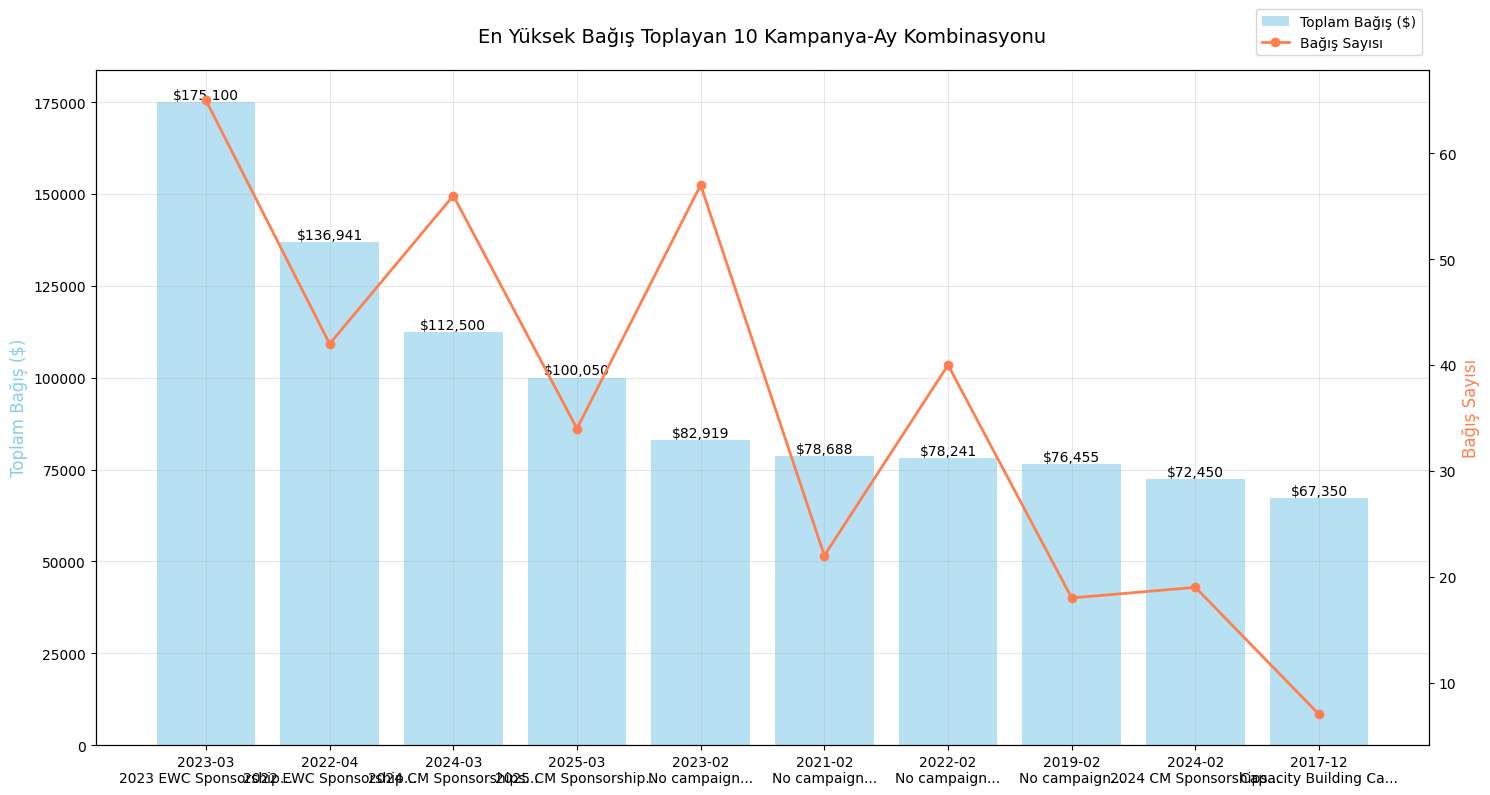

In [34]:
# Aylık kampanya performansı
df["year_month"] = df["closedate"].dt.to_period("M").dt.to_timestamp()

campaign_by_month = df.groupby(["year_month", "campaign.name"]).agg(
    Total_Donation=pd.NamedAgg(column="amount", aggfunc="sum"),
    Donation_Count=pd.NamedAgg(column="amount", aggfunc="count")
).reset_index()

# Tüm aylar dahil, toplam bağışa göre azalan sırala
campaign_by_month_sorted = campaign_by_month.sort_values(by="Total_Donation", ascending=False)

# İlk 10 kampanya-ay kombinasyonunu göster (isteğe bağlı artırabilirsin)
display(campaign_by_month_sorted.head(10))

import matplotlib.pyplot as plt
import seaborn as sns

# En başarılı 10 kampanya-ay kombinasyonu için görselleştirme
plt.figure(figsize=(15, 8))

# Ana grafik - Bağış Miktarları (Bar)
ax1 = plt.gca()
ax2 = ax1.twinx()  # İkinci y-ekseni için

# Veriyi hazırla - ilk 10'u al
top_10 = campaign_by_month_sorted.head(10)

# Bar plot - Toplam Bağış
bars = ax1.bar(range(len(top_10)), 
               top_10['Total_Donation'],
               alpha=0.6,
               color='skyblue',
               label='Toplam Bağış ($)')

# Line plot - Bağış Sayısı
line = ax2.plot(range(len(top_10)), 
                top_10['Donation_Count'],
                color='coral',
                marker='o',
                linewidth=2,
                label='Bağış Sayısı')

# Bar üzerine değerleri ekle
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2.,
             height,
             f'${height:,.0f}',
             ha='center',
             va='bottom',
             fontsize=10)

# X ekseni etiketleri
plt.xticks(range(len(top_10)),
           [f"{row['year_month'].strftime('%Y-%m')}\n{row['campaign.name'][:20]}..." 
            for _, row in top_10.iterrows()],
           rotation=45,
           ha='right')

# Başlık ve eksen etiketleri
ax1.set_title('En Yüksek Bağış Toplayan 10 Kampanya-Ay Kombinasyonu', 
              fontsize=14, 
              pad=20)
ax1.set_ylabel('Toplam Bağış ($)', color='skyblue', fontsize=12)
ax2.set_ylabel('Bağış Sayısı', color='coral', fontsize=12)

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, 
          loc='upper right', 
          bbox_to_anchor=(1, 1.1))

# Izgara
ax1.grid(True, alpha=0.3)

# Layout
plt.tight_layout()
plt.savefig("top10amoun-month.png", dpi=300)
plt.show()

 1. Mart & Sponsorluklar: Altın Kombinasyon
2023, 2024 ve 2025 Mart aylarında yapılan CM ve EWC Sponsorships kampanyaları, en yüksek bağışları toplamış.

Bu kampanyalar, hem yüksek işlem hacmi hem de yüksek kişi başı ortalama bağış sağlamış.

Sponsorluk kampanyaları, yıllar boyunca güvenilir gelir kaynağı olmuş.

🟡 2. “No Campaign” Etkisi:
Bazı dönemlerde kampanya adı belirtilmemiş (özellikle Şubat aylarında), ama bağışlar yine de yüksek.

Bu ya kampanya etiketinin eksik girildiği ya da doğal bağış akışının yüksek olduğu aylar olabilir.

Bu aylar stratejik olarak kampanya planlamasına dahil edilmeli, çünkü zaten bağış eğilimi yüksek.

🔵 3. 2017’den Bu Yana Büyüyen Trend:
2017’de Capacity Building Campaign sadece 7 işlemle 67K toplamış — bu, yüksek değerli bağışçılarla etkin çalışıldığını gösterir.

Bu tarz az sayıda ama büyük bağış getiren kampanyalar da büyüme stratejisinde önemli olabilir.

🎯 Yatırımcı Sunumu İçin Mesajlar:
“Son 3 yılda Mart ayında yapılan sponsorluk kampanyalarıyla istikrarlı bir gelir akışı yaratılmıştır. Bu kampanyalar yatırım ile genişletilebilir.”

“Kampanyasız dönemlerde dahi yüksek bağış hacmi elde edilebiliyor. Bu dönemler, sistemin organik gücünü gösteriyor.”

“Yıllara yayılan tutarlılık ve büyüme, ölçeklenebilir ve sürdürülebilir bağış yapısının göstergesidir.”

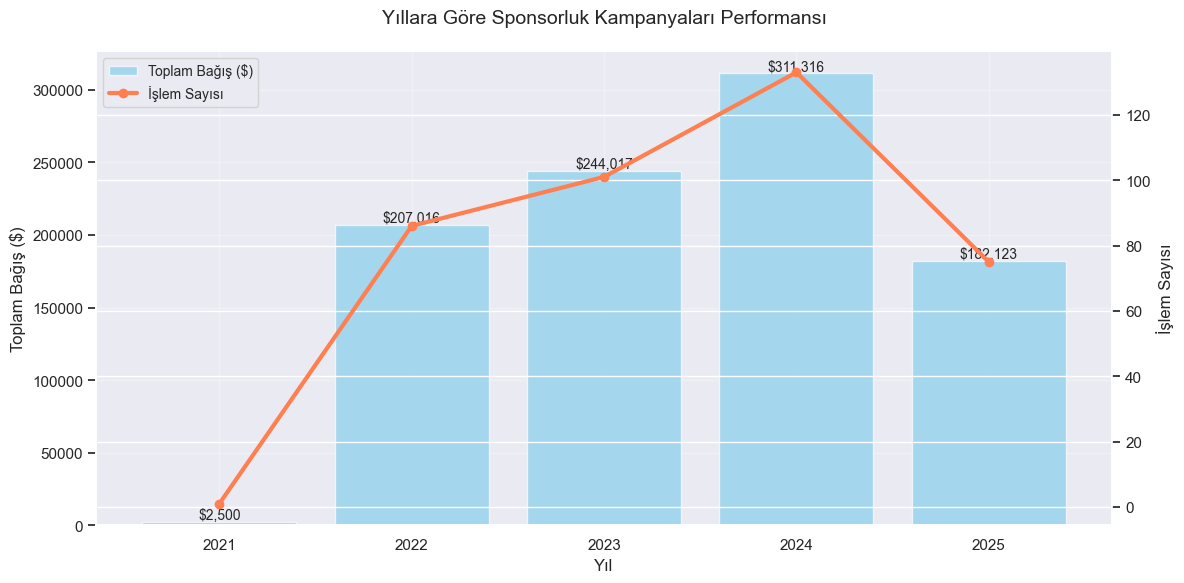

In [35]:

# Tarih bilgisi ve yıl çıkar
df["year"] = df["closedate"].dt.year

# Sponsorship içeren kampanyaları filtrele
sponsorship_df = df[df["campaign.name"].str.contains("Sponsorship", case=False, na=False)]

# Sponsorluk: Yıla göre toplam bağış ve işlem sayısı
sponsorship_by_year = sponsorship_df.groupby("year").agg(
    Total_Sponsorship_Donation=pd.NamedAgg(column="amount", aggfunc="sum"),
    Donation_Count_x=pd.NamedAgg(column="amount", aggfunc="count")
).reset_index()

# Seaborn temasını kullan
sns.set_theme()

# Grafik nesneleri oluştur (çift y ekseni için)
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Bar chart: Toplam bağış
bars = ax1.bar(
    sponsorship_by_year['year'],
    sponsorship_by_year['Total_Sponsorship_Donation'],
    alpha=0.7,
    color='skyblue',
    label='Toplam Bağış ($)'
)

# Line chart: İşlem sayısı
line = ax2.plot(
    sponsorship_by_year['year'],
    sponsorship_by_year['Donation_Count_x'],
    color='coral',
    linewidth=3,
    marker='o',
    label='İşlem Sayısı'
)

# Bar'ların üstüne değer yaz
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2., height,
             f'${height:,.0f}',
             ha='center', va='bottom', fontsize=10)

# Başlık ve eksen etiketleri
plt.title('Yıllara Göre Sponsorluk Kampanyaları Performansı', fontsize=14, pad=20)
ax1.set_xlabel('Yıl', fontsize=12)
ax1.set_ylabel('Toplam Bağış ($)', fontsize=12)
ax2.set_ylabel('İşlem Sayısı', fontsize=12)

# Legend (birleştirilmiş)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

# Izgara
ax1.grid(True, alpha=0.3)

# Görselleştirmeyi sıkıştır
plt.tight_layout()
plt.savefig("sponsorship.png", dpi=300)
plt.show()


 Yorumlar:
🟢 Sponsorluklar Yükselişte
2021'de deneme gibi tek bir işlemle başlayan sponsorluk kampanyaları, sonraki yıllarda çeyrek milyon doların üzerine çıkmış.

Özellikle 2024 yılında en yüksek seviyeye ulaşılmış.

💡 Yatırımcıya Mesaj:
"Son 4 yılda sponsorluk kampanyaları düzenli biçimde büyümüş ve güvenilir bir gelir modeli oluşturmuştur. Bu model yatırım ile daha da ölçeklenebilir."

In [36]:
def expanded_campaign_segment_v2(name):
    name = name.lower() if pd.notnull(name) else ""
    if "ewc" in name:
        return "EWC"
    elif "cm" in name:
        return "CM"
    elif "ekc" in name or "every kick counts" in name:
        return "EKC"
    elif "mch" in name:
        return "MCH"
    elif "lydie" in name or "loop" in name or "lap of love" in name:
        return "LL"
    elif "giving tuesday" in name:
        return "Giving Tuesday"
    elif any(k in name for k in ["birthday", "hbd", "wedding"]):
        return "Peer & Personal"
    elif any(k in name for k in ["honoring", "remember", "remembrance"]):
        return "Tribute & Memorial"
    elif any(k in name for k in ["walk", "run", "event", "gala", "challenge"]):
        return "Community Events"
    elif name == "no campaign":
        return "No Campaign"
    elif "individual donations" in name:
        return "Individual Donations"
    else:
        return "Other"


Segment	Açıklama
EWC	Empower Women Campaign
CM	Community Movement
EKC	Every Kick Counts – çocuk odaklı bağışlar
MCH	Maternal & Child Health
LL	Lydie’s Loop / Lap of Love – etkinlik bazlı
Giving Tuesday	Ulusal bağış günü
Peer & Personal	Doğum günü, düğün, kişisel fon toplama
Tribute & Memorial	Anma & hatıra amaçlı bağışlar
Community Events	Walk, gala, challenge, etkinlik bağışları
 Individual Giving	Bireysel ve serbest bağışlar,
 No Campaign kampanyasız olanlar
Other	Sınıflandırılamayan özel durumlar

In [37]:
# Segment sütununu güncelle
df["campaign_segment"] = df["campaign.name"].apply(expanded_campaign_segment_v2)

# Yeni segment dağılımını kontrol et
segment_summary = df.groupby("campaign_segment").agg(
    Total_Donation=("amount", "sum"),
    Donation_Count=("amount", "count")
).reset_index().sort_values(by="Total_Donation", ascending=False)

display(segment_summary)


campaign_segment  Total_Donation  Donation_Count
8            No Campaign      1002021.22            2969
3                    EWC       951141.21            2139
0                     CM       757485.71            1196
9                  Other       565787.34            1140
2                    EKC       346409.73            2274
6                     LL       177634.40            2543
7                    MCH       139800.00             315
4         Giving Tuesday       106140.33             750
5   Individual Donations        93367.39             809
1       Community Events        71743.10             521
11    Tribute & Memorial        16798.47             288
10       Peer & Personal         5608.19             121

1️⃣ No Campaign Segmenti (1M $+) — Sessiz Devinim
İçgörü:
Yalın bağış kayıtları (örneğin kampanyasız bireysel katkılar), toplam bağış hacminin en büyük segmentini oluşturdu.

Amerika'da karşılığı:
Bu, bireylerin etkili kampanya çağrısı olmadan da bağış yaptığı anlamına gelir. ABD’de bu, çoğu zaman:

Otomatik aylık bağışçılar

Vergi yılı sonunda yapılan katkılar

CRM'den tetiklenen kişisel e-posta zincirleriyle oluşan organik bağışlar şeklinde görülür.

Stratejik Not:
Bu sessiz katkı kanalı daha iyi görünür hale getirilirse, dijital pazarlama yatırım getirisi (ROI) yükselebilir.

2️⃣ EWC ve CM Segmentleri — Kurumsal Kimlik ve Topluluk Gücü
İçgörü:
Empower Women Campaign (EWC) ve Community Movement (CM), yüksek katılım ve orta-üst seviye gelirle dikkat çekiyor.

Amerika'da karşılığı:

EWC tipi kampanyalar, genellikle kurumsal sponsorlukla geniş kitleyi hedefleyen stratejilerdir. Başarısı, mesajın netliğine ve duygusal çağrısına bağlıdır.

CM kampanyaları, genellikle masa kaptanları, topluluk etkinlikleri, akşam yemekleri gibi fiziksel buluşmalarla desteklenir. Katılım odaklıdır.

Stratejik Not:
Her iki segment de büyümeye açık. EWC dijital kanallarla ölçeklenebilir; CM segmenti ise hibrit etkinliklerle zenginleştirilebilir.

3️⃣ EKC & MCH — Odaklı Mikro Kampanyalar
İçgörü:
Early Kids Campaign (EKC) ve Maternal & Child Health (MCH), görece daha küçük ama bağlı topluluklardan düzenli bağış alıyor.

Amerika'da karşılığı:

Bu kampanyalar genellikle çocuk odaklı hikayelere dayalı, duygusal tetikleyicisi yüksek kampanyalardır.

Sosyal medya ve okul bazlı destekçi zincirleriyle yayılırlar.

Stratejik Not:
MCH gibi kampanyalarda “impact reporting” (bağışın neye yaradığını anlatmak) çok önemlidir. EKC ise sadık bağışçılar için güçlü bir ilişki yönetimi alanı sunar.

4️⃣ Giving Tuesday — Ulusal Bağış Günü Kullanımı
İçgörü:
Giving Tuesday kampanyaları orta seviyede bağış toplamış, ama potansiyeli daha yüksek.

Amerika'da karşılığı:

Giving Tuesday, Şükran Günü sonrası yapılan ulusal bir bağış seferberliğidir. ABD’de yüz binlerce STK tarafından kullanılır.

Doğru segmentasyon + e-posta sıralaması + sosyal kanıt ile çok yüksek dönüşüm sağlayabilir.

Stratejik Not:
Bu kampanya yılda sadece bir gün yapılır, ama doğru planlamayla tüm yılın en çok bağış toplayan günü olabilir.

5️⃣ Peer & Personal / Tribute Segmentleri — Bireysel Yüz, Kurumsal Zemin
İçgörü:
Bu segmentler toplamda düşük bağış getiriyor ama işlem sayısı azımsanmayacak düzeyde.

Amerika'da karşılığı:

Doğum günleri, anma etkinlikleri, düğün fonlamaları gibi kampanyalar genellikle birey tarafından başlatılır ama organizasyonun platformuna ihtiyaç duyar.

Bu tarz kampanyalar duygusal bağ kurar, uzun vadeli sadakat sağlar.

Stratejik Not:
Bu alanda “DIY fundraising” (kendin yap fonlama) araçları sunulursa, dönüşüm %200+ artabilir. Salesforce, Classy, GiveButter gibi platformlar buna hazır entegrasyon sunar.

6️⃣ Community Events & LL (Lydie’s Loop) — Yüksek Katılım, Düşük Ortalama
İçgörü:
İşlem sayısı çok yüksek ama ortalama bağış düşük. Bu segment kitlesel kampanyaların sinyalini veriyor.

Amerika'da karşılığı:

“Fun Runs”, “Charity Walks”, “Loop Challenges” gibi fiziksel topluluk aktiviteleri. Bağışçı başına 5$–30$ arasında işlem olur.

Sosyal medya + fiziksel varlık birleşimiyle çalışır.

Stratejik Not:
Katılımı yüksek tutmak için oyunlaştırma, ödül seviyesi, “Team Captains” gibi yapılar entegre edilmelidir. Aynı zamanda merchandising fırsatıdır.

🎯 Genel Yorum ve Yatırımcıya Önerilecek Yaklaşım
Segment bazlı strateji, Amerikan bağış dünyasında bir zorunluluktur. Her segmentin bağış motivasyonu, içerik tonu ve dağıtım kanalı farklıdır.

Sistemin organik bağış alma kapasitesi yüksek. Bu kapasite otomasyon ve içerik desteğiyle görünür hale getirilmeli.

Sadakat oluşturma stratejisi zayıf olabilir. Bunu düzeltmek için yıl boyunca temalı kampanya dizileri planlanmalı (örneğin: "Spring Support Series").

Kurumsal fonlama alanında EWC ve MCH gibi segmentlerde ROI çok yüksek olabilir — bu alanlar yatırım önceliği taşımalı.

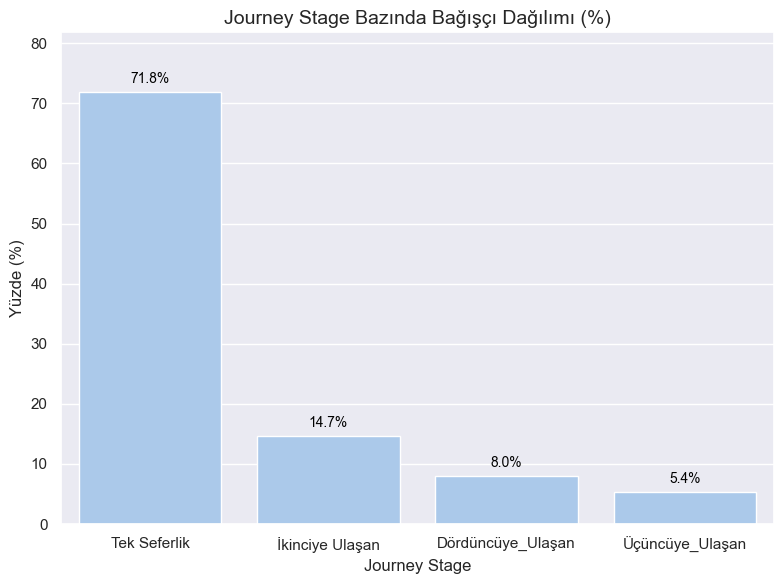

       Journey Stage  Donor Count  Percentage
0       Tek Seferlik         5890        71.8
1    İkinciye Ulaşan         1207        14.7
2  Dördüncüye_Ulaşan          657         8.0
3    Üçüncüye_Ulaşan          446         5.4


In [38]:
# Gerekli sütunları al
donor_journey_df = df[["contactid", "closedate", "amount"]].copy()

# Eksik verileri temizle
donor_journey_df = donor_journey_df.dropna(subset=["contactid", "closedate"])

# Bağışçının ilk ve son bağışı, toplam bağış ve sayısı
donor_summary = donor_journey_df.groupby("contactid").agg(
    First_Donation_Date=("closedate", "min"),
    Last_Donation_Date=("closedate", "max"),
    Total_Donations=("amount", "sum"),
    Donation_Count=("amount", "count")
).reset_index()

# Bağış aralıklarını hesapla
donor_journey_df = donor_journey_df.sort_values(["contactid", "closedate"])
donor_journey_df["prev_date"] = donor_journey_df.groupby("contactid")["closedate"].shift(1)
donor_journey_df["days_between"] = (donor_journey_df["closedate"] - donor_journey_df["prev_date"]).dt.days

# Ortalama bağış aralığı
donor_freq = donor_journey_df.groupby("contactid")["days_between"].mean().reset_index()
donor_freq = donor_freq.rename(columns={"days_between": "Avg_Days_Between"})

# Donör ömrü (gün)
donor_summary["Donor_Lifespan_Days"] = (
    donor_summary["Last_Donation_Date"] - donor_summary["First_Donation_Date"]
).dt.days

# Tüm veriyi birleştir
donor_journey = donor_summary.merge(donor_freq, on="contactid", how="left")

# Yolculuk segmenti oluştur
def journey_stage(row):
    if row["Donation_Count"] == 1:
        return "Tek Seferlik"
    elif row["Donation_Count"] == 2:
        return "İkinciye Ulaşan"
    elif row["Donation_Count"] >= 4 :
        return "Dördüncüye_Ulaşan"
    else:
        return "Üçüncüye_Ulaşan"

donor_journey["Journey_Stage"] = donor_journey.apply(journey_stage, axis=1)

# Her Journey Stage için bağışçı sayısı ve yüzdeyi hesapla
stage_distribution = donor_journey["Journey_Stage"].value_counts(normalize=False).reset_index()
stage_distribution.columns = ["Journey Stage", "Donor Count"]
stage_distribution["Percentage"] = (stage_distribution["Donor Count"] / stage_distribution["Donor Count"].sum()) * 100

# Yüzdelik değerleri 1 ondalık basamağa yuvarlayalım
stage_distribution["Percentage"] = stage_distribution["Percentage"].round(1)


# Grafik
plt.figure(figsize=(8, 6))
sns.set_palette("pastel")
barplot = sns.barplot(data=stage_distribution, x="Journey Stage", y="Percentage")

# Her bar üzerine label ekle
for index, row in stage_distribution.iterrows():
    barplot.text(index, row["Percentage"] + 1, f"{row['Percentage']}%", 
                 color='black', ha="center", va="bottom", fontsize=10)

plt.title("Journey Stage Bazında Bağışçı Dağılımı (%)", fontsize=14)
plt.ylabel("Yüzde (%)")
plt.xlabel("Journey Stage")
plt.ylim(0, stage_distribution["Percentage"].max() + 10)
plt.tight_layout()
plt.show()

# Dilersen veri tablosunu da görebilirsin
print(stage_distribution)

yorum ekle

In [39]:
# Her platform için toplam bağış tutarı, bağış sayısı ve bağışçı sayısı
platform_summary = df.groupby("platform__c").agg(
    Total_Donation=("amount", "sum"),
    Donation_Count=("amount", "count"),
    Donor_Count=("contactid", "nunique")
).reset_index()

# Ortalama işlem başı bağış
platform_summary["Avg_Donation"] = (platform_summary["Total_Donation"] / platform_summary["Donation_Count"]).round(2)

# Ortalama bağışçı başına toplam katkı
platform_summary["Avg_Per_Donor"] = (platform_summary["Total_Donation"] / platform_summary["Donor_Count"]).round(2)

# Toplam bağışa göre sıralama
platform_summary = platform_summary.sort_values(by="Total_Donation", ascending=False)

# Sonuçları yazdır
display(platform_summary)


platform__c  Total_Donation  Donation_Count  Donor_Count  \
19                       Qgiv      1352396.15            5481         3456   
5                       Check      1271682.00            1200          651   
6        Community Foundation       289129.75              45           24   
9              Direct Deposit       281836.36             124           73   
12                   FundEasy       185869.65             741          549   
18                   PledgeIt       174259.66            1999         1592   
3                 CTK Website       140167.30             943          614   
10                   Facebook       124322.24            2106         1480   
13                Give Lively       102078.49             936          603   
11                Frontstream        62231.38             125            6   
2                    Benevity        52679.55             335           51   
1                 Applied Art        38270.00             152          148   
22                 United Way        35043.28             146           25   
15                HBD Website        31855.00             184          154   
21                     Truist        29011.21              63            5   
0                  32Auctions        22474.13              57           55   
20                     Square        17336.00             112           83   
23                      Venmo         7710.50             111          107   
7   Cybergrants - CAF America         5535.00              41            9   
4                        Cash         3384.50              19           11   
24                  YourCause         2475.55              47            6   
16                  Instagram         1824.39              47           46   
8    Cybergrants - Nationwide         1260.00              34            3   
17                 Pledge.com          905.00              16           13   
14                   Grateful          200.00               1            1   

    Avg_Donation  Avg_Per_Donor  
19        246.74         391.32  
5        1059.73        1953.43  
6        6425.11       12047.07  
9        2272.87        3860.77  
12        250.84         338.56  
18         87.17         109.46  
3         148.64         228.29  
10         59.03          84.00  
13        109.06         169.28  
11        497.85       10371.90  
2         157.25        1032.93  
1         251.78         258.58  
22        240.02        1401.73  
15        173.12         206.85  
21        460.50        5802.24  
0         394.28         408.62  
20        154.79         208.87  
23         69.46          72.06  
7         135.00         615.00  
4         178.13         307.68  
24         52.67         412.59  
16         38.82          39.66  
8          37.06         420.00  
17         56.56          69.62  
14        200.00         200.00

 Qgiv – Ölçeklenebilir, Topluluk Odaklı Dijital Altyapı
1,35 milyon $ bağış

5.481 işlem, 3.456 bağışçı

Ortalama işlem: 246 $, kişi başı ortalama katkı: 391 $

Yorum:
Qgiv, etkinlik tabanlı ve peer-to-peer bağış toplama için güçlü bir platformdur. Hacmi yüksek, çünkü genelde yürüyüşler, farkındalık kampanyaları ve takım bazlı bağış organizasyonları için kullanılır.

Strateji: Geniş kitlelere ulaşmak için ideal. Liste büyütmek ve bağışçı tabanı oluşturmak için kullanılır. İlk bağış sonrası e-posta serileri, SMS ve hedefli kampanyalarla ikinci bağışa yönlendirme yapılmalı.

🏦 Check, Direct Deposit, Community Foundation – Yüksek Katkılı, Elit Kanallar
Check: 1,27 milyon $ – kişi başı ortalama: 1.953 $

Direct Deposit: 281K $ – kişi başı ortalama: 3.861 $

Community Foundation: Sadece 24 bağışçıdan 289K $ – kişi başı 12.047 $

Yorum:
Bu platformlar sıradan kanallar değildir. Genellikle:

Büyük bireysel bağışçılar (HNWIs),

Kurumsal sponsorluklar,

Vakıf destekleri, DAF (Donor-Advised Fund) yoluyla gelen bağışları temsil eder.

Strateji: Bu bağışçılar CRM sisteminde ayrı tutulmalı. Onlara özel “Major Donor” planları uygulanmalı: özel raporlar, aramalar, saha ziyaretleri gibi yüksek temas stratejileriyle desteklenmeli.

📣 Facebook, PledgeIt, FundEasy – Yüksek Erişimli, Düşük Katkılı
Facebook: 124K $ – kişi başı 84 $

PledgeIt: 174K $ – kişi başı 109 $

FundEasy: 185K $ – kişi başı 338 $

Yorum:
Bu platformlar çok sayıda kişiye ulaşır ama işlem başı katkı oldukça düşüktür. Genelde doğum günü bağışları, arkadaş aracılığıyla gelen bağışlar gibi ilk temas ortamlarıdır.

Strateji: Bu platformlar kazanım aracı olarak düşünülmeli. Bağış yapan kişiler hemen kurumun ana kanallarına (e-posta listesi, web sitesi) geçirilip orada sadakate dönüştürülmeli.

🧪 CTK Website, Give Lively – Kurumun Dijital Omurgası
CTK Website: 228 $ kişi başı ortalama

Give Lively: 169 $ kişi başı ortalama

Yorum:
Bunlar doğrudan kampanya sayfaları üzerinden gelen bağışları gösteriyor. Ortalama bağışlar orta düzeyde; bu kanallar upsell (üst seviye bağışa yönlendirme) ve tekrar bağış için potansiyel sunar.

Strateji: Web sayfası bağış formları A/B testine tabi tutulmalı, terk eden kullanıcılar için exit intent pop-up’lar ve retargeting (yeniden hedefleme) reklamları planlanmalı.

🧯 Uzun Kuyrukta Kalan Platformlar – Düşük Verim
Venmo, Instagram, YourCause, Cybergrants, Pledge.com gibi platformlar çok düşük katkı sağlıyor.

Yorum:
Bu kanallar:

Kullanım kolaylığı nedeniyle tercih edilmiş olabilir,

Veya kurumsal çalışanların sunduğu küçük bağışların yansıması olabilir.

Strateji: Eğer operasyonel yük yaratmıyorsa açık tutulabilir. Ancak pazarlama yatırımı yapılmamalı; içerik ve bütçe stratejisi bu kanallar üzerine kurulmaz.

🔚 Genel Değerlendirme
Qgiv ve CTK Website, kitlesel kampanyalar için iyi çalışır.

Check, Direct Deposit ve vakıf kanalları ise sürdürülebilir gelir ve yüksek bağlılık sağlar.

Facebook, PledgeIt, gibi kanallar bağışçı kazanımında etkilidir, ancak sadakat değil hacim yaratır.

Cybergrants, Instagram gibi platformlar pasif bırakılmalı, özel içerik veya bütçe ayırmaya gerek yoktur.
kaynakları her platformun doğal gücüne göre dağıt. Bu sayede bağış başı maliyet azalır, toplam getiri artar.

In [40]:
# Her platform ve kampanya segmenti kombinasyonu için özet metrikleri hesapla
platform_campaign_summary = df.groupby(["platform__c", "campaign_segment"]).agg(
    Total_Donation=("amount", "sum"),
    Donation_Count=("amount", "count"),
    Donor_Count=("contactid", "nunique")
).reset_index()

# Ortalama işlem başı bağış ve kişi başı toplam katkı
platform_campaign_summary["Avg_Donation"] = (platform_campaign_summary["Total_Donation"] / platform_campaign_summary["Donation_Count"]).round(2)
platform_campaign_summary["Avg_Per_Donor"] = (platform_campaign_summary["Total_Donation"] / platform_campaign_summary["Donor_Count"]).round(2)

# En yüksek toplam bağıştan en düşüğe sırala
platform_campaign_summary = platform_campaign_summary.sort_values(by="Total_Donation", ascending=False)

# Sonuçları görüntüle
display(platform_campaign_summary.head(10))  # İlk 10 satır


platform__c campaign_segment  Total_Donation  Donation_Count  \
103                  Qgiv              EWC       484995.53            1317   
21                  Check               CM       411648.25             274   
108                  Qgiv      No Campaign       384197.86             506   
24                  Check              EWC       262990.00             254   
39   Community Foundation      No Campaign       228750.00               8   
29                  Check      No Campaign       179152.95             175   
96               PledgeIt              EKC       162432.06            1867   
30                  Check            Other       154546.52             219   
106                  Qgiv               LL       153685.95            2461   
109                  Qgiv            Other       149163.13             159   

     Donor_Count  Avg_Donation  Avg_Per_Donor  
103         1134        368.26         427.69  
21           181       1502.37        2274.30  
108          376        759.28        1021.80  
24           178       1035.39        1477.47  
39             5      28593.75       45750.00  
29           105       1023.73        1706.22  
96          1486         87.00         109.31  
30           152        705.69        1016.75  
106         1333         62.45         115.29  
109          131        938.13        1138.65

High-dollar donations (10K $ üzeri) çoğunlukla etiketsiz kampanyalar ve doğrudan ilişki temelli platformlar üzerinden geliyor (Check, Direct Deposit, Foundation).

Segment bazlı bağış türüyle platform örtüşmesi çok net:

CM → Check

Peer-based düşük tutarlı kampanyalar (henüz tabloda görünmeyen PledgeIt, Facebook) → dijital ve sosyal medya odaklı

In [41]:
# Kampanya segmentine göre en verimli platformu bul
top_platforms_by_segment = platform_campaign_summary.sort_values(
    by=["campaign_segment", "Avg_Per_Donor"], ascending=[True, False]
)

# Her kampanya segmenti için en yüksek kişi başı katkıyı sağlayan platformu al
top_platforms_by_segment = top_platforms_by_segment.groupby("campaign_segment").first().reset_index()

# Sonuçları görüntüle
display(top_platforms_by_segment)


campaign_segment           platform__c  Total_Donation  \
0                     CM        Direct Deposit        53370.00   
1       Community Events                 Check        46841.45   
2                    EKC                 Check        91819.82   
3                    EWC  Community Foundation        29300.00   
4         Giving Tuesday                 Check        17325.00   
5   Individual Donations  Community Foundation         5829.75   
6                     LL                 Check         8340.00   
7                    MCH        Direct Deposit        58500.00   
8            No Campaign  Community Foundation       228750.00   
9                  Other        Direct Deposit        84025.00   
10       Peer & Personal           Give Lively         5558.19   
11    Tribute & Memorial                 Check          500.00   

    Donation_Count  Donor_Count  Avg_Donation  Avg_Per_Donor  
0               19           14       2808.95        3812.14  
1               80           77        585.52         608.33  
2               79           40       1162.28        2295.50  
3                9            6       3255.56        4883.33  
4               11            9       1575.00        1925.00  
5                4            4       1457.44        1457.44  
6               17           14        490.59         595.71  
7                8            4       7312.50       14625.00  
8                8            5      28593.75       45750.00  
9                7            5      12003.57       16805.00  
10             120           55         46.32         101.06  
11               1            1        500.00         500.00

In [42]:
# Platform başına en fazla bağış getiren kampanya segmentini bul
top_segments_by_platform = platform_campaign_summary.sort_values(
    by=["platform__c", "Total_Donation"], ascending=[True, False]
)

# Her platform için en çok gelir sağlayan kampanya segmentini al
top_segments_by_platform = top_segments_by_platform.groupby("platform__c").first().reset_index()

# Sonuçları görüntüle
display(top_segments_by_platform)


platform__c      campaign_segment  Total_Donation  \
0                  32Auctions                    CM        22474.13   
1                 Applied Art                   EWC        38270.00   
2                    Benevity                 Other        23913.27   
3                 CTK Website           No Campaign        63602.20   
4                        Cash                   EKC         2080.00   
5                       Check                    CM       411648.25   
6        Community Foundation           No Campaign       228750.00   
7   Cybergrants - CAF America           No Campaign         2384.00   
8    Cybergrants - Nationwide           No Campaign         1125.00   
9              Direct Deposit                 Other        84025.00   
10                   Facebook           No Campaign        59842.10   
11                Frontstream                 Other        34468.87   
12                   FundEasy                    CM        85592.28   
13                Give Lively                    CM        36425.53   
14                   Grateful  Individual Donations          200.00   
15                HBD Website                 Other        13973.00   
16                  Instagram  Individual Donations          936.35   
17                 Pledge.com  Individual Donations          905.00   
18                   PledgeIt                   EKC       162432.06   
19                       Qgiv                   EWC       484995.53   
20                     Square                    CM        12021.00   
21                     Truist                 Other        29011.21   
22                 United Way                 Other        18540.74   
23                      Venmo                    CM         7320.50   
24                  YourCause           No Campaign         2213.50   

    Donation_Count  Donor_Count  Avg_Donation  Avg_Per_Donor  
0               57           55        394.28         408.62  
1              152          148        251.78         258.58  
2               53           16        451.19        1494.58  
3              531          361        119.78         176.18  
4                5            1        416.00        2080.00  
5              274          181       1502.37        2274.30  
6                8            5      28593.75       45750.00  
7               23            6        103.65         397.33  
8               23            3         48.91         375.00  
9                7            5      12003.57       16805.00  
10            1260          966         47.49          61.95  
11              67            3        514.46       11489.62  
12             391          323        218.91         264.99  
13             208          191        175.12         190.71  
14               1            1        200.00         200.00  
15              56           50        249.52         279.46  
16              17           16         55.08          58.52  
17              16           13         56.56          69.62  
18            1867         1486         87.00         109.31  
19            1317         1134        368.26         427.69  
20              59           50        203.75         240.42  
21              63            5        460.50        5802.24  
22              97           19        191.14         975.83  
23             103          100         71.07          73.20  
24              33            5         67.08         442.70

SORU 1: Hangi kampanya türü hangi platform için daha uygun?
🟩 Check
En yüksek katkı Other, CM, ve EWC kampanya segmentlerinden geliyor.

Ortalama bağış tutarı ve kişi başı katkı çok yüksek.

Yorum:
Check, geleneksel bağışçıların kullandığı bir kanal. Özellikle gala, sponsorluk, kurumsal bağış ya da board ilişkili bağışlar için uygundur.

✅ Uygun kampanyalar: CM (Community Movement), EWC, Major Donor ilişkili kampanyalar
🚫 Uygun değil: Peer & Personal, Giving Tuesday gibi mikro kampanyalar

🟨 Qgiv
Toplamda en yüksek hacmi getiriyor ama bağış tutarları görece düşük.

Çoğunlukla kitlesel kampanyalar (peer-to-peer, yürüyüşler) için kullanılmış.

Yorum:
Qgiv, etkinlik bazlı topluluk kampanyaları için ideal. Hedef kitle daha geniş ama katkı tutarları düşük.

✅ Uygun kampanyalar: EKC, CM, LL (Lydie's Loop), Community Events
🚫 Uygun değil: Major Donor ilişkili veya vakıf temelli segmentler

🟦 Community Foundation
Çok az bağışçıdan çok büyük bağışlar geliyor. Genellikle Donor-Advised Fund (DAF) bağışları.

Yorum:
Bu kanal, kurumsal ya da vakıf fonlarına bağlı bağışlar için kullanılır. Takip süreçleri önemlidir (grant reporting, teşekkür vs.).

✅ Uygun kampanyalar: MCH, EWC, Other (vakıf destekli projeler)
🚫 Uygun değil: Peer & Personal gibi bireysel mikro kampanyalar

🟥 Facebook, PledgeIt, FundEasy
Çok sayıda bağışçı ama kişi başı katkı çok düşük.

Bu kanallar, sosyal medya kaynaklı, kişisel çağrı kampanyalarıyla ilişkili.

Yorum:
Sadakat değil, farkındalık yaratmak için ideal. İlk temas kanalı gibi kullanılmalı.

✅ Uygun kampanyalar: Peer & Personal, Giving Tuesday, Tribute
🚫 Uygun değil: Yüksek tutarlı kurumsal kampanyalar

🔁 SORU 2: Kampanya ve platform eşleşmelerinde yeniden yapılandırma yapılmalı mı?
✅ Evet. Çünkü:
Platformlar farklı davranış kalıplarını yansıtıyor.

Check/Direct Deposit → Sadık, yüksek değerli bağışçılar

Facebook/PledgeIt → Hızlı erişim ama düşük tutarlı katkılar

Bazı kampanya türleri yanlış platformda kullanılıyor olabilir.
Örneğin:

CM gibi yüksek katkı beklenen kampanyalar sadece Qgiv veya PledgeIt’te çalıştırılıyorsa potansiyel kaçırılıyor.

Peer kampanyaları Check veya Direct Deposit üzerinden geliyorsa bağışçı deneyimi zayıf kalabilir.

Bağış başına maliyet (CPDR) platforma göre ciddi farklılık gösteriyor.
Yüksek ROI için kampanya–platform uyumu netleştirilmeli.

🧭 Stratejik Öneriler:
Kampanya Segmenti	Uygun Platformlar	Aksiyon
CM, EWC, MCH	Check, Direct Deposit, Foundations	Major Donor stratejisi, kişiselleştirme, özel raporlama
EKC, LL, Tribute	Qgiv, FundEasy, PledgeIt	Etkinlik kampanyaları, gamification, sosyal entegrasyon
Peer & Personal	Facebook, Instagram	Sadakat zinciriyle büyütülmeli
Giving Tuesday	CTK Website, Give Lively, Qgiv	Mobil uyumlu sayfa, e-posta otomatizasyonu



In [43]:
# Yıl, ay ve yıl-ay birleşimini oluştur
df["year"] = df["closedate"].dt.year
df["month"] = df["closedate"].dt.month
df["year_month"] = df["closedate"].dt.to_period("M").dt.to_timestamp()

# Aylık bağış zamanlaması özeti
monthly_summary = df.groupby("year_month").agg(
    Total_Donation=("amount", "sum"),
    Donation_Count=("amount", "count")
).reset_index()

# Sonuçları gör
display(monthly_summary)


year_month  Total_Donation  Donation_Count
0   2017-01-01          155.00               3
1   2017-02-01         5419.39              31
2   2017-03-01        21640.00             144
3   2017-04-01        28432.00             158
4   2017-05-01         4145.00              13
..         ...             ...             ...
97  2025-11-01        35136.59              16
98  2025-12-01          636.59              10
99  2026-01-01          375.91               3
100 2026-02-01          375.91               3
101 2026-03-01          100.00               2

[102 rows x 3 columns]

In [44]:
# Kampanya türlerine göre aylık bağış özeti
monthly_by_segment = df.groupby(["month", "campaign_segment"]).agg(
    Total_Donation=("amount", "sum"),
    Donation_Count=("amount", "count")
).reset_index()

# Ay bilgisi sıralı olsun
monthly_by_segment = monthly_by_segment.sort_values(by=["month", "Total_Donation"], ascending=[True, False])

# Sonuçları gör
display(monthly_by_segment)


month    campaign_segment  Total_Donation  Donation_Count
0        1                  CM        73894.07              38
5        1         No Campaign        42399.31             161
6        1               Other        40651.67             132
2        1                 EWC        36527.00              24
4        1                 MCH        22500.00               2
..     ...                 ...             ...             ...
111     12                 EWC        10051.45               5
109     12                  CM         1500.00               1
114     12                  LL          235.00               2
117     12     Peer & Personal          192.04               5
118     12  Tribute & Memorial           61.96               2

[119 rows x 4 columns]

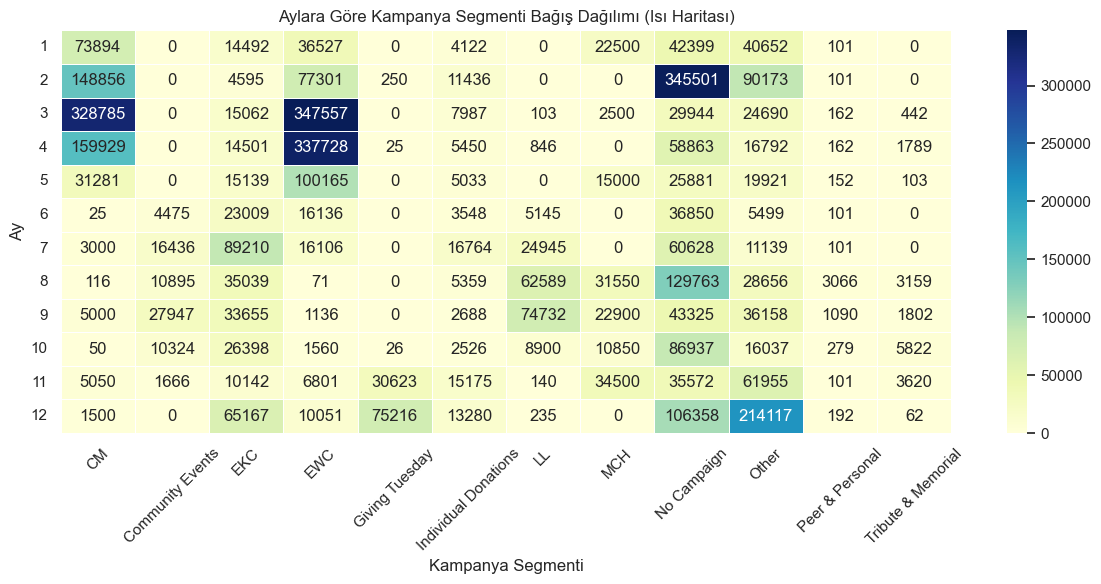

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Isı haritası için veri: Aylar x Kampanya Segmentleri (bağış miktarları)
heatmap_data = df.groupby(["month", "campaign_segment"])["amount"].sum().unstack(fill_value=0)

# Görsel
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=0.5)
plt.title("Aylara Göre Kampanya Segmenti Bağış Dağılımı (Isı Haritası)")
plt.xlabel("Kampanya Segmenti")
plt.ylabel("Ay")
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


📅 KAMPANYA ZAMANLAMASI STRATEJİLERİ (Segment Bazlı)
🟨 EWC (Empower Women Campaign)
Yoğunluk: Şubat – Mart – Nisan

Önerilen dönem: Kadınlar Günü ve Bahar başı (8 Mart civarı)

Strateji: Sosyal medya entegrasyonu, hikâye temelli e-posta zinciri, matching campaign yapılabilir.

🟩 CM (Community Movement)
Yoğunluk: Mart – Haziran

Önerilen dönem: Bahar ve Yaz başı etkinlik dönemi

Strateji: Gala, yürüyüş, yerel etkinlik kampanyaları bu döneme denk getirilip offline + online bağış senkronize edilmeli.

🟧 EKC (Every Kick Counts)
Yoğunluk: Ağustos – Ekim

Önerilen dönem: Okula dönüş dönemi + sonbahar

Strateji: Okul içi katılım, sosyal medya challenge, genç destekçi mobilizasyonu kullanılmalı.

🟦 LL (Lydie’s Loop / Tribute Campaigns)
Yoğunluk: Mayıs – Eylül

Önerilen dönem: İlkbahar-sonbahar arası

Strateji: Yürüyüş etkinlikleri, "In Memory Of" bağış formatları ve hatıra odaklı anlatımlar desteklenmeli.

🟥 Giving Tuesday
Yoğunluk: Kasım sonu

Önerilen dönem: Şükran Günü sonrasındaki Salı

Strateji: Yüksek hacimli tek günlük kampanya için 2 hafta önceden e-posta zinciri, sosyal medya “countdown” ve eşleşme çağrısı kurgulanmalı.

⚪ Peer & Personal / Birthday / Tribute
Yıl geneline yayılır, ama özel günler (doğum günü, yıl dönümü, anma) üzerinden bağış tetiklenir

Strateji: Otomatik e-posta hatırlatıcılar, kişiye özel bağış sayfası linkleriyle desteklenmeli.

📌 GENEL KAMPANYA TAKVİMİ ÖNERİSİ
Ay	Kampanya Odakları
Ocak	Sadakat e-postaları, yıl başlangıç kampanyası
Şubat	EWC, Kadınlar Günü ön hazırlığı
Mart	EWC, CM başlatılır
Nisan	CM, LL, Matching Funds
Mayıs	LL, Tribute, Event-based Giving
Haziran	CM kapanışı, okula veda
Temmuz	Sessiz ay — planlama zamanı
Ağustos	EKC başlatılır
Eylül	EKC, Tribute
Ekim	Giving Tuesday ön duyuruları
Kasım	Giving Tuesday + Year-End Previews
Aralık	Year-End push, vergi teşvikli bağışlar

In [46]:
import pandas as pd

# En verimli (kişi başı ortalama bağışı en yüksek) platformları kampanya segmentine göre bul
top_platforms = platform_campaign_summary.sort_values(
    by=["campaign_segment", "Avg_Per_Donor"], ascending=[True, False]
)

# En çok toplam bağış getireni alternatif olarak düşünebiliriz (ama Avg_Per_Donor'dan farklı)
alt_platforms = platform_campaign_summary.sort_values(
    by=["campaign_segment", "Total_Donation"], ascending=[True, False]
)

# Her segment için önerilen ve alternatif platformları alalım
recommended = top_platforms.groupby("campaign_segment").first().reset_index()
alternative = alt_platforms.groupby("campaign_segment").first().reset_index()

# Matris tablosunu oluştur
platform_match_matrix = recommended[["campaign_segment", "platform__c"]].merge(
    alternative[["campaign_segment", "platform__c"]],
    on="campaign_segment",
    suffixes=("_recommended", "_alternative")
)

# Sonuçları göster
display(platform_match_matrix)


campaign_segment platform__c_recommended platform__c_alternative
0                     CM          Direct Deposit                   Check
1       Community Events                   Check                   Check
2                    EKC                   Check                PledgeIt
3                    EWC    Community Foundation                    Qgiv
4         Giving Tuesday                   Check                Facebook
5   Individual Donations    Community Foundation                   Check
6                     LL                   Check                    Qgiv
7                    MCH          Direct Deposit                   Check
8            No Campaign    Community Foundation                    Qgiv
9                  Other          Direct Deposit                   Check
10       Peer & Personal             Give Lively             Give Lively
11    Tribute & Memorial                   Check                    Qgiv

In [47]:
# Sütun adlarını sadeleştir
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]

# Temel metrikler: Toplam bağış, işlem ve bağışçı sayısı
platform_kpis = df.groupby("platform__c").agg(
    total_donation=("amount", "sum"),
    donation_count=("amount", "count"),
    donor_count=("contactid", "nunique")
).reset_index()

# Ortalama metrikler
platform_kpis["avg_donation"] = (platform_kpis["total_donation"] / platform_kpis["donation_count"]).round(2)
platform_kpis["avg_per_donor"] = (platform_kpis["total_donation"] / platform_kpis["donor_count"]).round(2)

# Repeat donor hesaplaması
donor_platform_counts = df.groupby(["platform__c", "contactid"]).size().reset_index(name="donation_count")
repeat_donors = donor_platform_counts[donor_platform_counts["donation_count"] > 1]
repeat_by_platform = repeat_donors.groupby("platform__c")["contactid"].nunique().reset_index()
repeat_by_platform.columns = ["platform__c", "repeat_donor_count"]

# Ana tabloya bağla
platform_kpis = platform_kpis.merge(repeat_by_platform, on="platform__c", how="left")
platform_kpis["repeat_donor_count"] = platform_kpis["repeat_donor_count"].fillna(0)

# Repeat donor oranı
platform_kpis["repeat_donor_rate_%"] = (
    (platform_kpis["repeat_donor_count"] / platform_kpis["donor_count"]) * 100
).round(1)

# ROI benzeri skor: Sadakat × Ortalama Bağış
platform_kpis["conversion_potential"] = (
    platform_kpis["repeat_donor_rate_%"] * platform_kpis["avg_donation"]
).round(1)

# Sonuçları ROI skoruna göre sırala
platform_kpis = platform_kpis.sort_values(by="conversion_potential", ascending=False)

# Görüntüle
display(platform_kpis)


platform__c  total_donation  donation_count  donor_count  \
6        Community Foundation       289129.75              45           24   
9              Direct Deposit       281836.36             124           73   
21                     Truist        29011.21              63            5   
11                Frontstream        62231.38             125            6   
5                       Check      1271682.00            1200          651   
22                 United Way        35043.28             146           25   
7   Cybergrants - CAF America         5535.00              41            9   
2                    Benevity        52679.55             335           51   
19                       Qgiv      1352396.15            5481         3456   
12                   FundEasy       185869.65             741          549   
20                     Square        17336.00             112           83   
8    Cybergrants - Nationwide         1260.00              34            3   
3                 CTK Website       140167.30             943          614   
15                HBD Website        31855.00             184          154   
24                  YourCause         2475.55              47            6   
4                        Cash         3384.50              19           11   
0                  32Auctions        22474.13              57           55   
18                   PledgeIt       174259.66            1999         1592   
13                Give Lively       102078.49             936          603   
10                   Facebook       124322.24            2106         1480   
1                 Applied Art        38270.00             152          148   
17                 Pledge.com          905.00              16           13   
23                      Venmo         7710.50             111          107   
16                  Instagram         1824.39              47           46   
14                   Grateful          200.00               1            1   

    avg_donation  avg_per_donor  repeat_donor_count  repeat_donor_rate_%  \
6        6425.11       12047.07                10.0                 41.7   
9        2272.87        3860.77                27.0                 37.0   
21        460.50        5802.24                 5.0                100.0   
11        497.85       10371.90                 5.0                 83.3   
5        1059.73        1953.43               214.0                 32.9   
22        240.02        1401.73                19.0                 76.0   
7         135.00         615.00                 6.0                 66.7   
2         157.25        1032.93                28.0                 54.9   
19        246.74         391.32               995.0                 28.8   
12        250.84         338.56               131.0                 23.9   
20        154.79         208.87                25.0                 30.1   
8          37.06         420.00                 2.0                 66.7   
3         148.64         228.29                95.0                 15.5   
15        173.12         206.85                17.0                 11.0   
24         52.67         412.59                 2.0                 33.3   
4         178.13         307.68                 1.0                  9.1   
0         394.28         408.62                 2.0                  3.6   
18         87.17         109.46               243.0                 15.3   
13        109.06         169.28                70.0                 11.6   
10         59.03          84.00               274.0                 18.5   
1         251.78         258.58                 4.0                  2.7   
17         56.56          69.62                 1.0                  7.7   
23         69.46          72.06                 3.0                  2.8   
16         38.82          39.66                 1.0                  2.2   
14        200.00         200.00                 0.0                  0.0   

    conversi

In [48]:
# Sütun adlarını sadeleştir (isteğe bağlı)
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]

# Temel KPI'lar: toplam bağış, bağış sayısı, donor sayısı
platform_kpis = df.groupby("platform__c").agg(
    total_donation=("amount", "sum"),
    donation_count=("amount", "count"),
    donor_count=("contactid", "nunique")
).reset_index()

# Ortalama bağış tutarları
platform_kpis["avg_donation"] = (platform_kpis["total_donation"] / platform_kpis["donation_count"]).round(2)
platform_kpis["avg_per_donor"] = (platform_kpis["total_donation"] / platform_kpis["donor_count"]).round(2)

# Repeat donor hesaplama
donor_counts = df.groupby(["platform__c", "contactid"]).size().reset_index(name="donation_count")
repeat_donors = donor_counts[donor_counts["donation_count"] > 1]
repeat_by_platform = repeat_donors.groupby("platform__c")["contactid"].nunique().reset_index()
repeat_by_platform.columns = ["platform__c", "repeat_donor_count"]

# Bağlantı ve hesaplamalar
platform_kpis = platform_kpis.merge(repeat_by_platform, on="platform__c", how="left")
platform_kpis["repeat_donor_count"] = platform_kpis["repeat_donor_count"].fillna(0)
platform_kpis["repeat_donor_rate_%"] = (
    (platform_kpis["repeat_donor_count"] / platform_kpis["donor_count"]) * 100
).round(1)

# ROI benzeri skor: Sadakat × Ortalama Bağış
platform_kpis["conversion_potential"] = (
    platform_kpis["repeat_donor_rate_%"] * platform_kpis["avg_donation"]
).round(1)


In [49]:
# Belirli eşiklerle düşük ROI'li platformları ayıkla
low_roi_platforms = platform_kpis[
    (platform_kpis["avg_donation"] < 100) &
    (platform_kpis["repeat_donor_rate_%"] < 15) &
    (platform_kpis["conversion_potential"] < 5000)
].copy()

# Sonuçları sırala
low_roi_platforms = low_roi_platforms.sort_values(by="conversion_potential")


In [52]:
# ROI skoruna göre strateji etiketi oluştur
def kaynak_onceligi(row):
    if row["conversion_potential"] >= 50000:
        return "Yüksek Öncelik (Ana Yatırım)"
    elif row["conversion_potential"] >= 10000:
        return "Orta Öncelik (Geliştirilebilir)"
    elif row["conversion_potential"] >= 5000:
        return "Düşük Öncelik (Sınırlı Destek)"
    else:
        return "Pasif Kanal (Yatırım Önceliği Yok)"

platform_kpis["yatirim_stratejisi"] = platform_kpis.apply(kaynak_onceligi, axis=1)


 Yorumlama Rehberi (A
Senin verdiğin tabloyu anlamlandırmak için her segmenti kısaca açıklayayım:

🔴 Pasif Kanal (15 platform, 1.4K ROI ortalaması)
Ortalama bağışçı başına katkı sadece $213

Sadakat oranı %15’in altında

Platformlar: Venmo, Instagram, Facebook gibi mikro bağış kaynakları olabilir

Yorum:
Bu kanallar bağış hacmi yaratmakta zayıf. Sadakat yaratmıyorlar. Önerilen: Yalnızca destekleyici olarak sistemde kalmalı, ama yatırım veya içerik eforu yapılmamalı.

🔵 Düşük Öncelik (4 platform, 7.6K ROI)
Ortalama katkı düşük ama sadakat nispeten orta (%43)

Platformlar genelde eski sistemler (örn: FundEasy, Give Lively)

Yorum:
Tamamen terk edilmeli değil. Örneğin yıllık kampanya dönemlerinde aktif hale getirilebilir ama rutin bağış stratejisinde yer almamalı.

🟡 Orta Öncelik (4 platform, 35K ROI)
Sadakat çok yüksek (%73), ortalama katkı da güçlü ($4.8K)

Az sayıda platformla büyük bağış toplama potansiyeli var

Yorum:
Bu segment ölçeklenebilir. Belki Qgiv gibi platformlar burada yer alıyor. Hafif stratejik yatırımla “Yüksek Öncelik” seviyesine çıkabilirler.

🟢 Yüksek Öncelik (2 platform, 176K ROI)
En yüksek sadakat & katkı & ROI

Bunlar büyük ihtimalle: Check, Direct Deposit veya Community Foundation

Yorum:
Bu segment senin "bağış omurgan". CRM yatırımı, teşekkür e-postaları, özel raporlar gibi “major donor” ilişkileri bu platformlar üzerinden yürütülmeli.

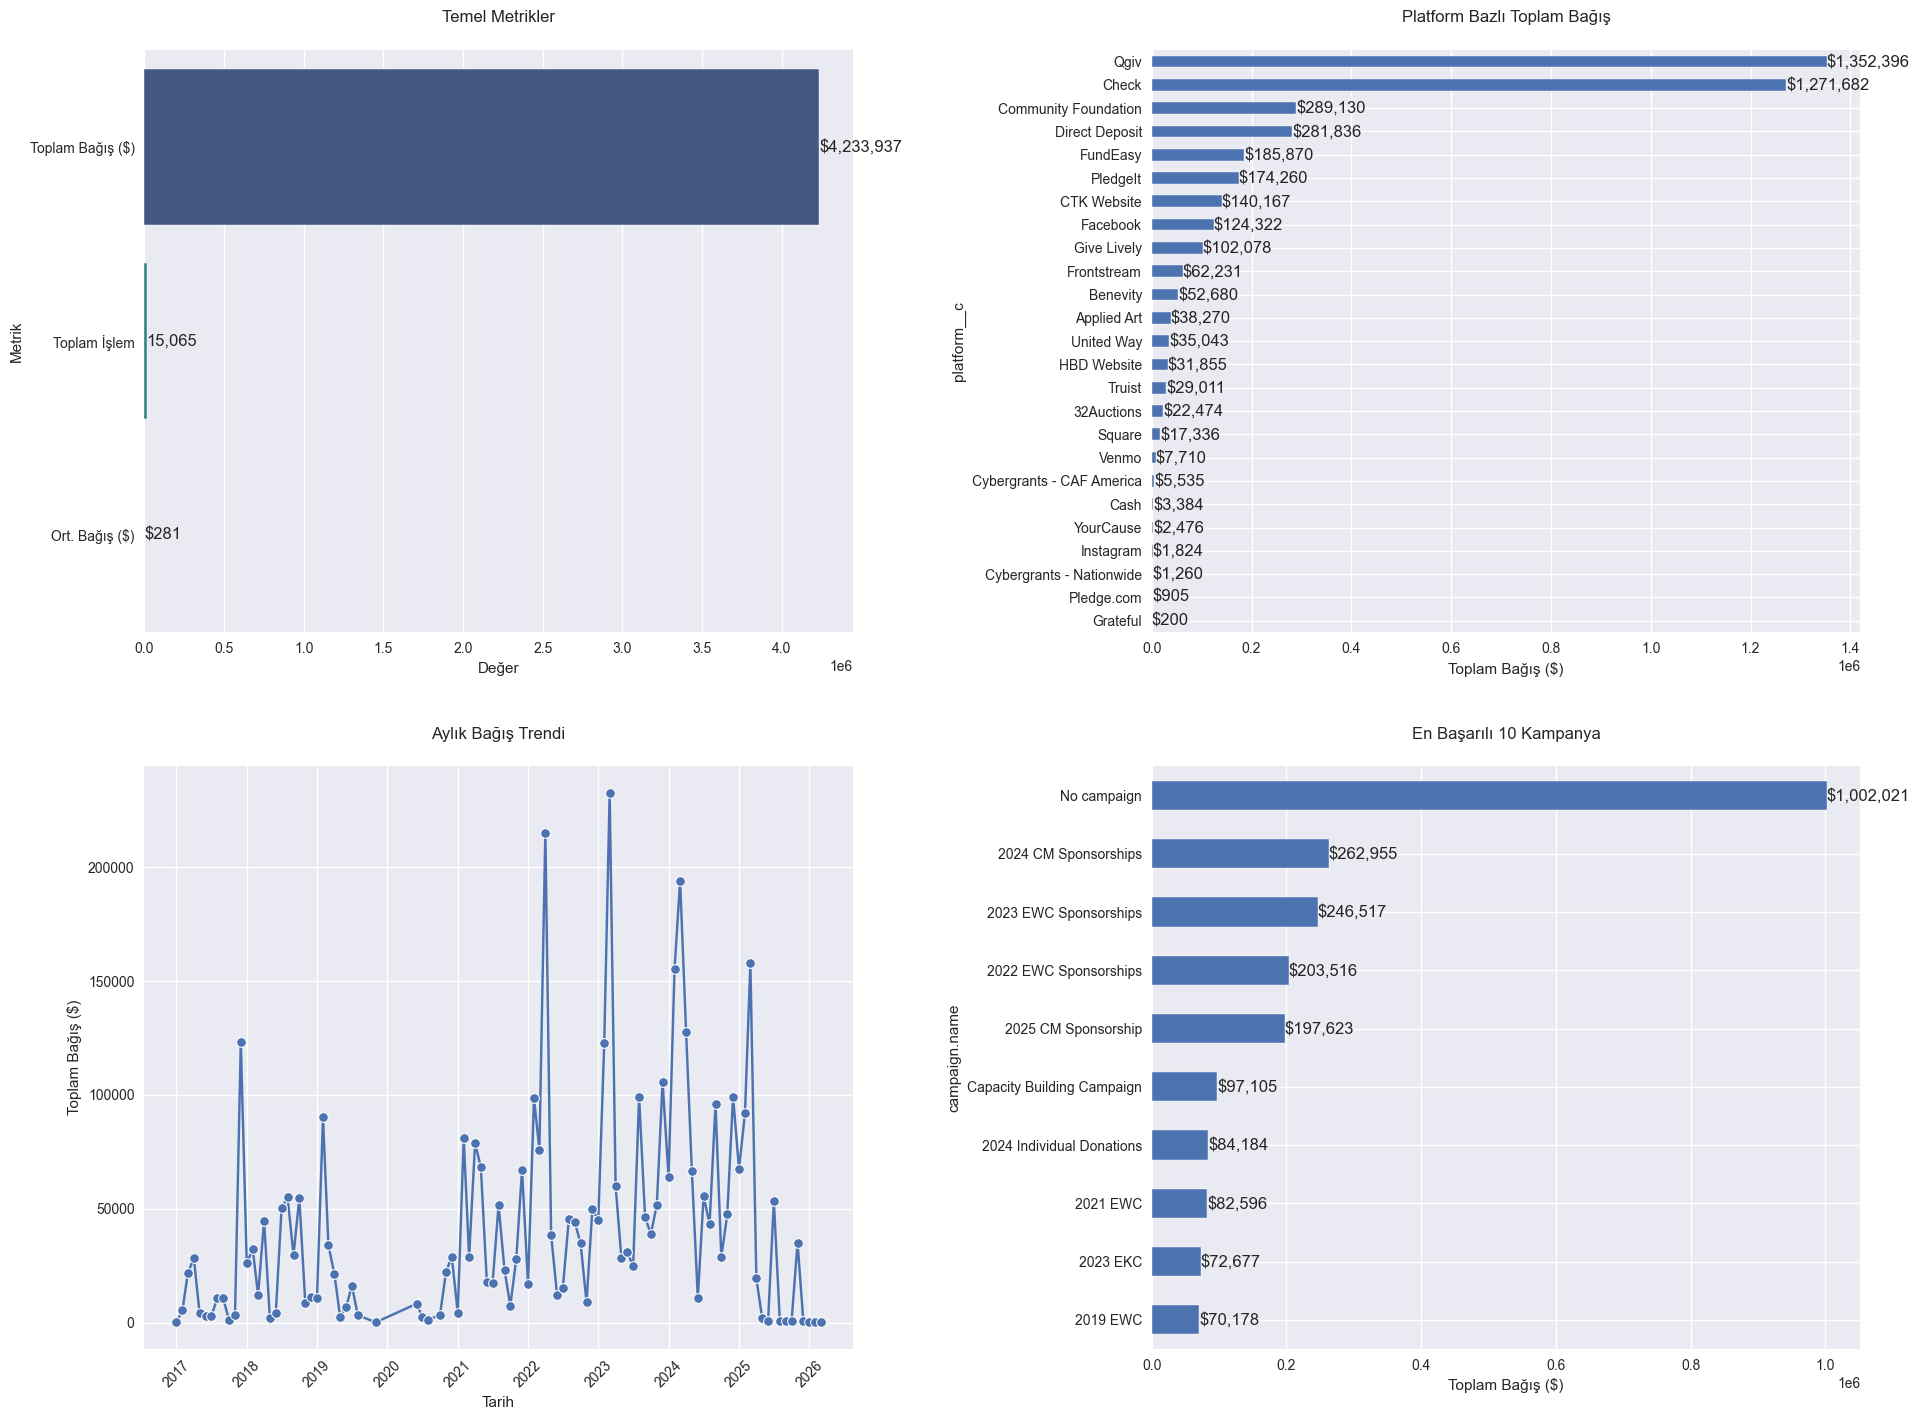

KeyError: 'recordytype.name'

<Figure size 1200x600 with 0 Axes>

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

# Geçerli stil kullan
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (15, 10)


# Ana dashboard görselleştirmesi
fig = plt.figure(figsize=(20, 15))

# 1. Toplam Bağış ve İşlem Sayısı (Sol Üst)
ax1 = plt.subplot(2, 2, 1)
total_amount = df['amount'].sum()
total_transactions = len(df)
avg_donation = total_amount / total_transactions

metrics = pd.DataFrame({
    'Metrik': ['Toplam Bağış ($)', 'Toplam İşlem', 'Ort. Bağış ($)'],
    'Değer': [total_amount, total_transactions, avg_donation]
})

# Yatay bar plot
bars = sns.barplot(data=metrics, y='Metrik', x='Değer', palette='viridis', ax=ax1)
ax1.set_title('Temel Metrikler', pad=20)

# Bar değerlerini ekle
for i, v in enumerate(metrics['Değer']):
    if i == 0 or i == 2:  # Para değerleri için
        ax1.text(v, i, f'${v:,.0f}', va='center')
    else:  # İşlem sayısı için
        ax1.text(v, i, f'{v:,.0f}', va='center')

# 2. Platform Bazlı Bağış Dağılımı (Sağ Üst)
ax2 = plt.subplot(2, 2, 2)
platform_summary = df.groupby('platform__c')['amount'].sum().sort_values(ascending=True)
platform_summary.plot(kind='barh', ax=ax2)
ax2.set_title('Platform Bazlı Toplam Bağış', pad=20)
ax2.set_xlabel('Toplam Bağış ($)')

# Bar değerlerini ekle
for i, v in enumerate(platform_summary):
    ax2.text(v, i, f'${v:,.0f}', va='center')

# 3. Zaman Serisi Analizi (Sol Alt)
ax3 = plt.subplot(2, 2, 3)
df['closedate'] = pd.to_datetime(df['closedate'])
monthly_donations = df.groupby(df['closedate'].dt.to_period('M'))['amount'].sum().reset_index()
monthly_donations['closedate'] = monthly_donations['closedate'].dt.to_timestamp()

sns.lineplot(data=monthly_donations, x='closedate', y='amount', ax=ax3, marker='o')
ax3.set_title('Aylık Bağış Trendi', pad=20)
ax3.set_xlabel('Tarih')
ax3.set_ylabel('Toplam Bağış ($)')
plt.xticks(rotation=45)

# 4. Kampanya Performansı (Sağ Alt)
ax4 = plt.subplot(2, 2, 4)
campaign_summary = df.groupby('campaign.name')['amount'].sum().sort_values(ascending=True).tail(10)
campaign_summary.plot(kind='barh', ax=ax4)
ax4.set_title('En Başarılı 10 Kampanya', pad=20)
ax4.set_xlabel('Toplam Bağış ($)')

# Bar değerlerini ekle
for i, v in enumerate(campaign_summary):
    ax4.text(v, i, f'${v:,.0f}', va='center')

plt.tight_layout(pad=3.0)
plt.savefig("dashboard.png", dpi=300, bbox_inches='tight')
plt.show()

# Ek analiz: Record Type bazlı dağılım
plt.figure(figsize=(12, 6))
record_type_summary = df.groupby('recordytype.name').agg({
    'amount': ['sum', 'count'],
    'contactid': 'nunique'
}).round(2)

record_type_summary.columns = ['Total_Amount', 'Transaction_Count', 'Unique_Donors']
record_type_summary = record_type_summary.sort_values('Total_Amount', ascending=True)

# Record Type bazlı bağış dağılımı
record_type_summary['Total_Amount'].plot(kind='barh')
plt.title('Record Type Bazlı Toplam Bağış')
plt.xlabel('Toplam Bağış ($)')

# Bar değerlerini ekle
for i, v in enumerate(record_type_summary['Total_Amount']):
    plt.text(v, i, f'${v:,.0f}', va='center')

plt.tight_layout()
plt.savefig("record_type_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

In [54]:
df.columns

Index(['opp._id', 'contactid', 'recordtype.name', 'account.name', 'amount',
       'platform__c', 'closedate', 'stagename', 'campaign.name', 'year_month',
       'quarter', 'year', 'campaign_segment', 'month'],
      dtype='object')

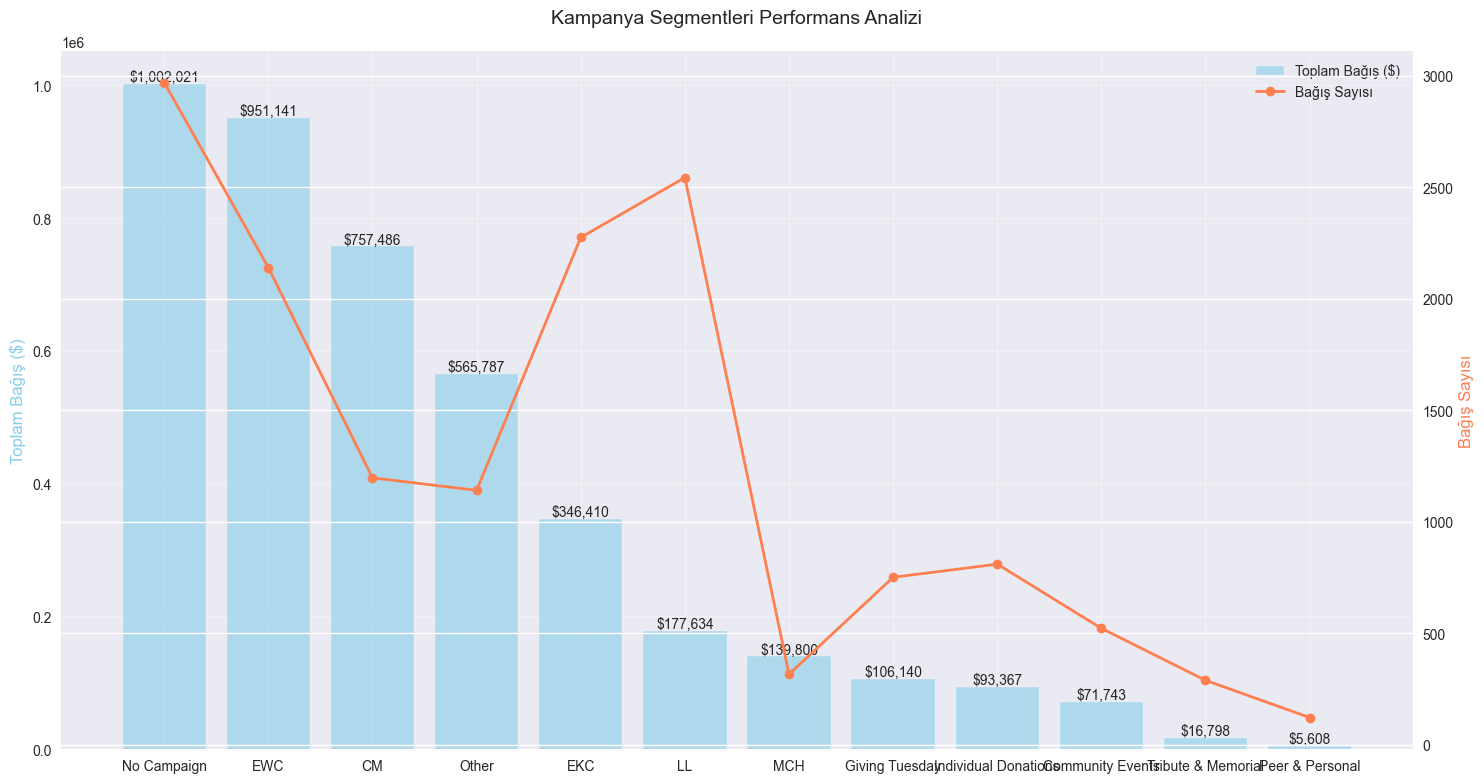

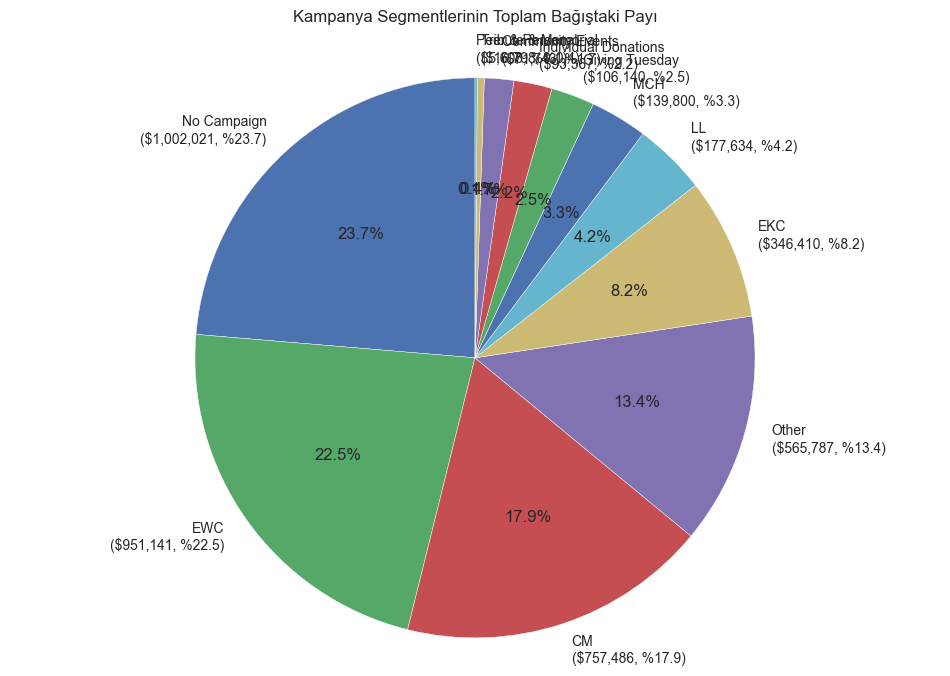

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Figür boyutunu ayarla
plt.figure(figsize=(15, 8))

# Ana grafik - çift y ekseni için hazırlık
ax1 = plt.gca()
ax2 = ax1.twinx()

# Bar plot - Toplam Bağış
bars = ax1.bar(range(len(segment_summary)), 
               segment_summary['Total_Donation'],
               alpha=0.6,
               color='skyblue',
               label='Toplam Bağış ($)')

# Line plot - Bağış Sayısı
line = ax2.plot(range(len(segment_summary)), 
                segment_summary['Donation_Count'],
                color='coral',
                marker='o',
                linewidth=2,
                label='Bağış Sayısı')

# Bar üzerine değerleri ekle
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2.,
             height,
             f'${height:,.0f}',
             ha='center',
             va='bottom',
             fontsize=10)

# X ekseni etiketleri
plt.xticks(range(len(segment_summary)),
           segment_summary['campaign_segment'],
           rotation=45,
           ha='right')

# Başlık ve eksen etiketleri
ax1.set_title('Kampanya Segmentleri Performans Analizi', 
              fontsize=14, 
              pad=20)
ax1.set_ylabel('Toplam Bağış ($)', color='skyblue', fontsize=12)
ax2.set_ylabel('Bağış Sayısı', color='coral', fontsize=12)

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, 
          loc='upper right')

# Izgara
ax1.grid(True, alpha=0.3)

# Layout
plt.tight_layout()

# Kaydet ve göster
plt.savefig("segment_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

# Pasta grafik için yüzde hesapla
total = segment_summary['Total_Donation'].sum()
segment_summary['Percentage'] = (segment_summary['Total_Donation'] / total * 100).round(1)

# Pasta grafik
plt.figure(figsize=(12, 8))
plt.pie(segment_summary['Total_Donation'], 
        labels=[f"{segment}\n(${value:,.0f}, %{pct})" 
                for segment, value, pct in zip(segment_summary['campaign_segment'], 
                                            segment_summary['Total_Donation'],
                                            segment_summary['Percentage'])],
        autopct='%1.1f%%',
        startangle=90)
plt.title('Kampanya Segmentlerinin Toplam Bağıştaki Payı', pad=20)
plt.axis('equal')

# Kaydet ve göster
plt.savefig("segment_pie.png", dpi=300, bbox_inches='tight')
plt.show()

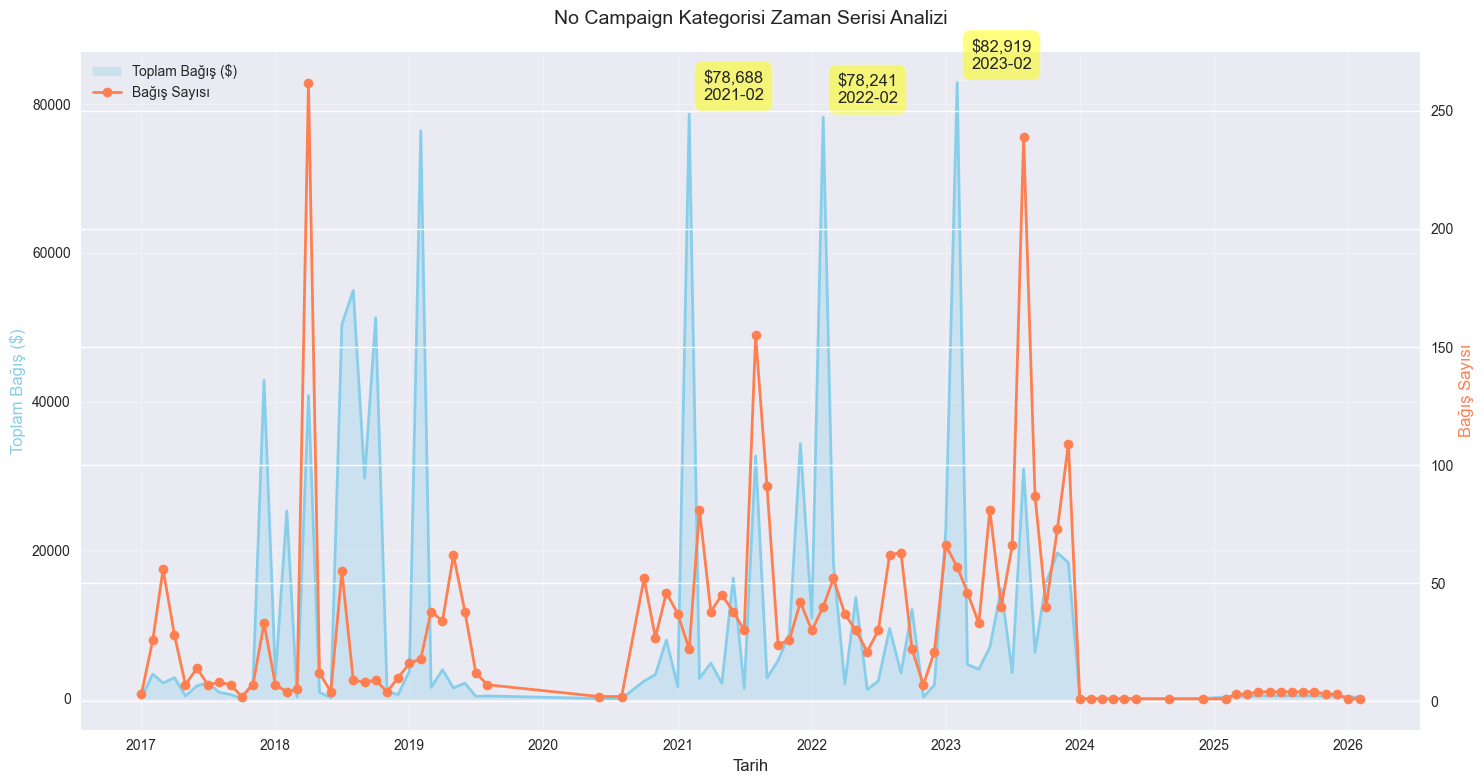


No Campaign İstatistikleri:
Ortalama Aylık Bağış: $10,659.80
En Düşük Aylık Bağış: $48.20
En Yüksek Aylık Bağış: $82,919.10

Ortalama Aylık İşlem: 32
En Düşük Aylık İşlem: 1
En Yüksek Aylık İşlem: 262


In [56]:


# No Campaign kategorisindeki bağışları filtrele
no_campaign_df = df[df['campaign_segment'] == 'No Campaign'].copy()

# Aylık trend analizi
monthly_no_campaign = no_campaign_df.groupby('year_month').agg(
    Total_Donation=('amount', 'sum'),
    Donation_Count=('amount', 'count')
).reset_index()

# Görselleştirme
plt.figure(figsize=(15, 8))

# Ana grafik - çift y ekseni için hazırlık
ax1 = plt.gca()
ax2 = ax1.twinx()

# Bağış miktarı için alan grafiği
ax1.fill_between(monthly_no_campaign['year_month'], 
                 monthly_no_campaign['Total_Donation'],
                 alpha=0.3, color='skyblue', label='Toplam Bağış ($)')
ax1.plot(monthly_no_campaign['year_month'], 
         monthly_no_campaign['Total_Donation'],
         color='skyblue', linewidth=2)

# İşlem sayısı için çizgi grafik
line = ax2.plot(monthly_no_campaign['year_month'],
                monthly_no_campaign['Donation_Count'],
                color='coral', linewidth=2, marker='o',
                label='Bağış Sayısı')

# En yüksek 3 noktayı işaretle
top_3_months = monthly_no_campaign.nlargest(3, 'Total_Donation')
for idx, row in top_3_months.iterrows():
    ax1.annotate(f"${row['Total_Donation']:,.0f}\n{row['year_month'].strftime('%Y-%m')}",
                 xy=(row['year_month'], row['Total_Donation']),
                 xytext=(10, 10), textcoords='offset points',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 arrowprops=dict(arrowstyle='->'))

# Başlık ve eksen etiketleri
plt.title('No Campaign Kategorisi Zaman Serisi Analizi', fontsize=14, pad=20)
ax1.set_xlabel('Tarih', fontsize=12)
ax1.set_ylabel('Toplam Bağış ($)', color='skyblue', fontsize=12)
ax2.set_ylabel('Bağış Sayısı', color='coral', fontsize=12)

# X ekseni tarih formatı
plt.xticks(rotation=45)

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Izgara
ax1.grid(True, alpha=0.3)

# Layout
plt.tight_layout()

# Kaydet ve göster
plt.savefig("no_campaign_trend.png", dpi=300, bbox_inches='tight')
plt.show()

# İstatistiksel özet
summary_stats = monthly_no_campaign.agg({
    'Total_Donation': ['mean', 'min', 'max'],
    'Donation_Count': ['mean', 'min', 'max']
}).round(2)

print("\nNo Campaign İstatistikleri:")
print(f"Ortalama Aylık Bağış: ${summary_stats['Total_Donation']['mean']:,.2f}")
print(f"En Düşük Aylık Bağış: ${summary_stats['Total_Donation']['min']:,.2f}")
print(f"En Yüksek Aylık Bağış: ${summary_stats['Total_Donation']['max']:,.2f}")
print(f"\nOrtalama Aylık İşlem: {summary_stats['Donation_Count']['mean']:.0f}")
print(f"En Düşük Aylık İşlem: {summary_stats['Donation_Count']['min']:.0f}")
print(f"En Yüksek Aylık İşlem: {summary_stats['Donation_Count']['max']:.0f}")

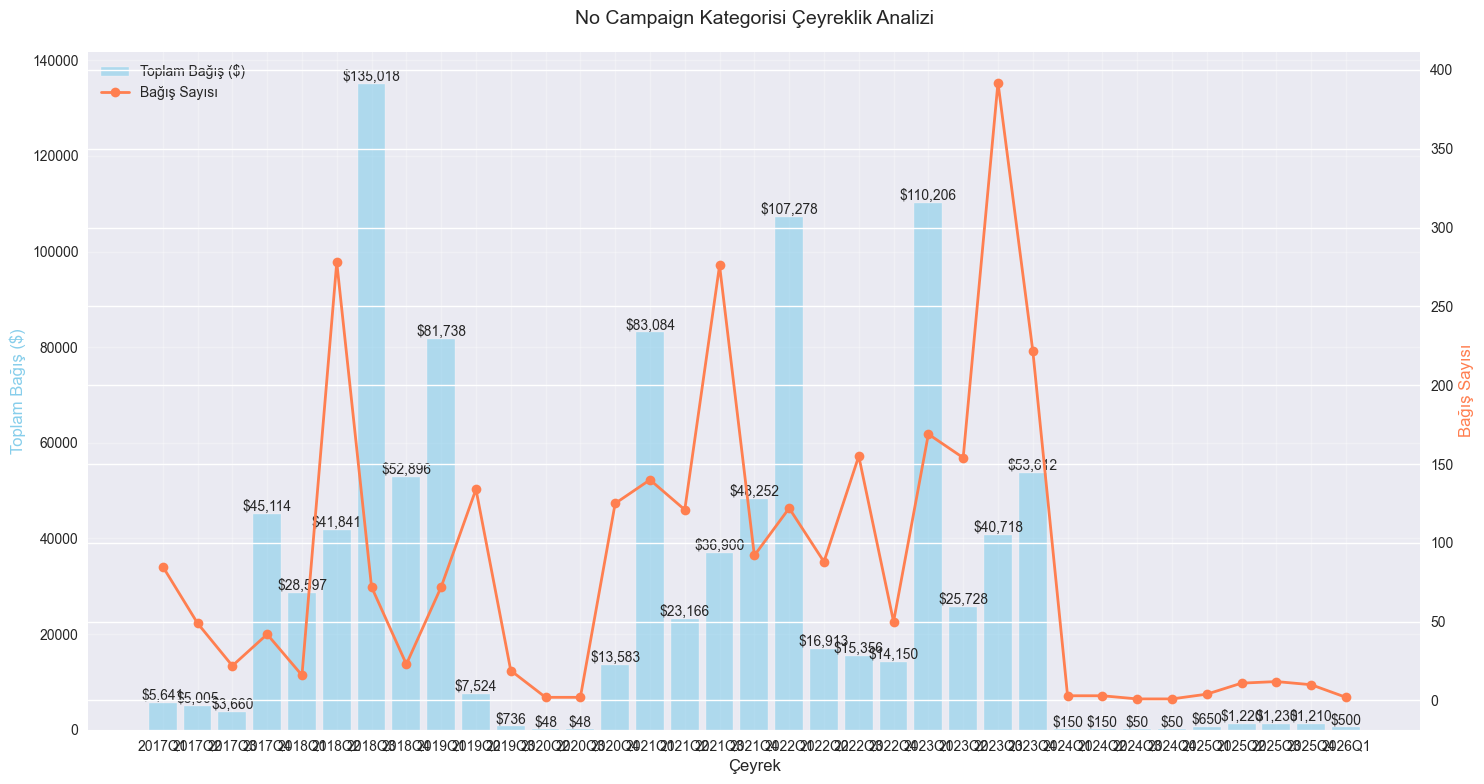


No Campaign Çeyreklik İstatistikler:
Ortalama Çeyreklik Bağış: $28,629.18
En Düşük Çeyreklik Bağış: $48.20
En Yüksek Çeyreklik Bağış: $135,018.00

Ortalama Çeyreklik İşlem: 85
En Düşük Çeyreklik İşlem: 1
En Yüksek Çeyreklik İşlem: 392


In [57]:
# No Campaign kategorisindeki bağışları filtrele
no_campaign_df = df[df['campaign_segment'] == 'No Campaign'].copy()

# Çeyrek bilgisini ekle
no_campaign_df['quarter'] = no_campaign_df['closedate'].dt.to_period('Q').astype(str)

# Çeyreklik trend analizi
quarterly_no_campaign = no_campaign_df.groupby('quarter').agg(
    Total_Donation=('amount', 'sum'),
    Donation_Count=('amount', 'count')
).reset_index()

# Görselleştirme
plt.figure(figsize=(15, 8))

# Ana grafik - çift y ekseni için hazırlık
ax1 = plt.gca()
ax2 = ax1.twinx()

# Bağış miktarı için bar grafiği
bars = ax1.bar(range(len(quarterly_no_campaign)), 
               quarterly_no_campaign['Total_Donation'],
               alpha=0.6, 
               color='skyblue', 
               label='Toplam Bağış ($)')

# İşlem sayısı için çizgi grafik
line = ax2.plot(range(len(quarterly_no_campaign)),
                quarterly_no_campaign['Donation_Count'],
                color='coral', 
                linewidth=2, 
                marker='o',
                label='Bağış Sayısı')

# Bar üzerine değerleri ekle
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2.,
             height,
             f'${height:,.0f}',
             ha='center',
             va='bottom',
             fontsize=10)

# X ekseni etiketleri
plt.xticks(range(len(quarterly_no_campaign)),
           quarterly_no_campaign['quarter'],
           rotation=45)

# Başlık ve eksen etiketleri
plt.title('No Campaign Kategorisi Çeyreklik Analizi', fontsize=14, pad=20)
ax1.set_xlabel('Çeyrek', fontsize=12)
ax1.set_ylabel('Toplam Bağış ($)', color='skyblue', fontsize=12)
ax2.set_ylabel('Bağış Sayısı', color='coral', fontsize=12)

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Izgara
ax1.grid(True, alpha=0.3)

# Layout
plt.tight_layout()

# Kaydet ve göster
plt.savefig("no_campaign_quarterly.png", dpi=300, bbox_inches='tight')
plt.show()

# İstatistiksel özet
summary_stats = quarterly_no_campaign.agg({
    'Total_Donation': ['mean', 'min', 'max'],
    'Donation_Count': ['mean', 'min', 'max']
}).round(2)

print("\nNo Campaign Çeyreklik İstatistikler:")
print(f"Ortalama Çeyreklik Bağış: ${summary_stats['Total_Donation']['mean']:,.2f}")
print(f"En Düşük Çeyreklik Bağış: ${summary_stats['Total_Donation']['min']:,.2f}")
print(f"En Yüksek Çeyreklik Bağış: ${summary_stats['Total_Donation']['max']:,.2f}")
print(f"\nOrtalama Çeyreklik İşlem: {summary_stats['Donation_Count']['mean']:.0f}")
print(f"En Düşük Çeyreklik İşlem: {summary_stats['Donation_Count']['min']:.0f}")
print(f"En Yüksek Çeyreklik İşlem: {summary_stats['Donation_Count']['max']:.0f}")

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# Platform-based revenue analysis
platform_summary = df.groupby("platform__c").agg(
    Total_Revenue=("amount", "sum"),
    Transaction_Count=("amount", "count"),
    Unique_Donors=("contactid", "nunique")
).reset_index()

# Calculate percentage contribution to total revenue
total_revenue = platform_summary["Total_Revenue"].sum()
platform_summary["Revenue_Percentage"] = (platform_summary["Total_Revenue"] / total_revenue * 100).round(2)

# Display the table
# Sort platform_summary by Revenue_Percentage in descending order
platform_summary = platform_summary.sort_values(by="Revenue_Percentage", ascending=True)

platform_summary.sort_values(by="Revenue_Percentage", ascending=False)


platform__c  Total_Revenue  Transaction_Count  \
19                       Qgiv     1352396.15               5481   
5                       Check     1271682.00               1200   
6        Community Foundation      289129.75                 45   
9              Direct Deposit      281836.36                124   
12                   FundEasy      185869.65                741   
18                   PledgeIt      174259.66               1999   
3                 CTK Website      140167.30                943   
10                   Facebook      124322.24               2106   
13                Give Lively      102078.49                936   
11                Frontstream       62231.38                125   
2                    Benevity       52679.55                335   
1                 Applied Art       38270.00                152   
22                 United Way       35043.28                146   
15                HBD Website       31855.00                184   
21                     Truist       29011.21                 63   
0                  32Auctions       22474.13                 57   
20                     Square       17336.00                112   
23                      Venmo        7710.50                111   
7   Cybergrants - CAF America        5535.00                 41   
4                        Cash        3384.50                 19   
24                  YourCause        2475.55                 47   
16                  Instagram        1824.39                 47   
8    Cybergrants - Nationwide        1260.00                 34   
17                 Pledge.com         905.00                 16   
14                   Grateful         200.00                  1   

    Unique_Donors  Revenue_Percentage  
19           3456               31.94  
5             651               30.04  
6              24                6.83  
9              73                6.66  
12            549                4.39  
18           1592                4.12  
3             614                3.31  
10           1480                2.94  
13            603                2.41  
11              6                1.47  
2              51                1.24  
1             148                0.90  
22             25                0.83  
15            154                0.75  
21              5                0.69  
0              55                0.53  
20             83                0.41  
23            107                0.18  
7               9                0.13  
4              11                0.08  
24              6                0.06  
16             46                0.04  
8               3                0.03  
17             13                0.02  
14              1                0.00

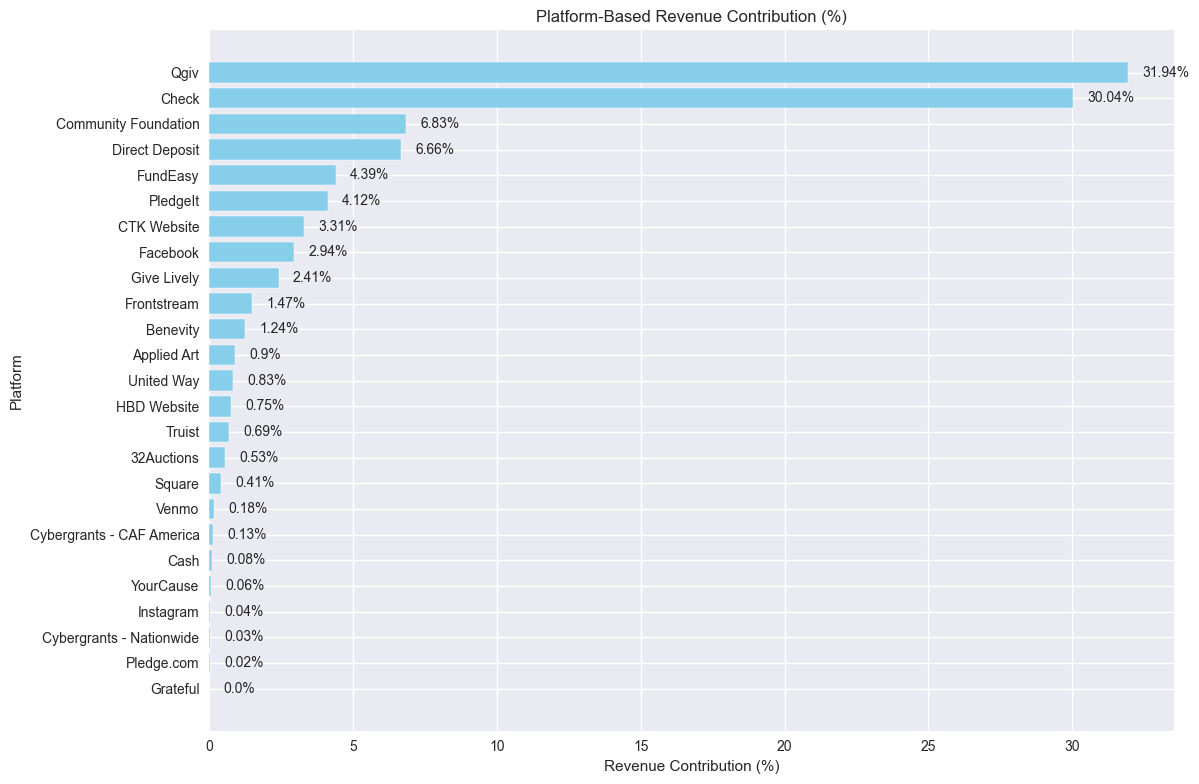

In [62]:

# Plot the percentage contribution graph
plt.figure(figsize=(12, 8))
plt.barh(platform_summary["platform__c"], platform_summary["Revenue_Percentage"], color="skyblue")
plt.xlabel("Revenue Contribution (%)")
plt.ylabel("Platform")
plt.title("Platform-Based Revenue Contribution (%)")
plt.tight_layout()

# Add percentage labels to the bars
for index, value in enumerate(platform_summary["Revenue_Percentage"]):
    plt.text(value + 0.5, index, f"{value}%", va="center", fontsize=10)

# Show the plot
plt.show()

In [72]:
import plotly.express as px
import pandas as pd

# Highlight the top 5 platforms
platform_summary['Highlight'] = platform_summary['Revenue_Percentage'].rank(ascending=False) <= 5

# Create the bar chart
fig = px.bar(
    platform_summary,
    x="Revenue_Percentage",
    y="platform__c",
    color="Highlight",
    color_discrete_map={True: "gold", False: "skyblue"},
    orientation="h",
    title="Platform-Based Revenue Contribution (%)",
    labels={"Revenue_Percentage": "Revenue Contribution (%)", "platform__c": "Platform"},
    text="Revenue_Percentage"  # 👈 Barların üstüne metin eklendi
)

# Update layout and trace for better visualization
fig.update_traces(
    texttemplate='%{text:.2f}%',  # 👈 Yüzdeleri %.2f formatında göster
    textposition='outside'        # 👈 Metni barın dışında göster
)

fig.update_layout(
    xaxis_title="Revenue Contribution (%)",
    yaxis_title="Platform",
    showlegend=False,
    height=600
)

# Show the plot
fig.show()
